In [23]:

from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
import numpy as np
import os
import pandas as pd
from time import time
import matplotlib.pyplot as plt
# from binarized_modules import  BinarizeLinear,BinarizeConv2d

In [24]:
import os
# os.chdir("/home/earapidis/Desktop/BinaryNet.pytorch")
os.getcwd()

'/shares/bulk/earapidis/dev/BinarizedNN'

In [25]:
import models.binarized_modules

In [26]:
import importlib
importlib.reload(models.binarized_modules)

<module 'models.binarized_modules' from '/shares/bulk/earapidis/dev/BinarizedNN/models/binarized_modules.py'>

In [27]:
from models.binarized_modules import  BinarizeLinear,BinarizeConv2d
from models.binarized_modules import  Binarize,HingeLoss


In [28]:
# cuda = False
cuda = True

In [29]:
kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}

In [30]:
batch_size = 64
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=batch_size, shuffle=True, **kwargs)

In [31]:
test_batch_size=1000

In [32]:
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('data', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=test_batch_size, shuffle=True, **kwargs)

In [33]:
import models.lenet_5
import models.mlp

importlib.reload(models.lenet_5)
importlib.reload(models.mlp)

<module 'models.mlp' from '/shares/bulk/earapidis/dev/BinarizedNN/models/mlp.py'>

In [34]:
# from models.lenet_5 import BinarizedLeNet5_NoBN as Net
from models.lenet_5 import BinarizedLeNet5_BN as Net
# from models.mlp import MLP as Net

In [35]:
# from mnist_bnn import Net

model = Net()
# model = Net()
if cuda:
    torch.cuda.set_device(0)
    model.cuda()


In [36]:
lr=0.001

In [37]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)


In [38]:
log_interval=100

In [39]:
def train(epoch):
    model.train()
    losses = []
    for batch_idx, (data, target) in enumerate(train_loader):
        # print(batch_idx)
        if cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)

        if epoch%40==0:
            optimizer.param_groups[0]['lr']=optimizer.param_groups[0]['lr']*0.1

        optimizer.zero_grad()
        loss.backward()
        
        for p in list(model.parameters()):
            if hasattr(p,'org'):
                p.data.copy_(p.org)
        optimizer.step()
        for p in list(model.parameters()):
            if hasattr(p,'org'):
                p.org.copy_(p.data.clamp_(-1,1))
        losses.append(loss.item())
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
    return losses

In [40]:
def test():
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            if cuda:
                data, target = data.cuda(), target.cuda()
            data, target = Variable(data), Variable(target)
            output = model(data)
            test_loss += criterion(output, target).item() # sum up batch loss
            pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(target.data.view_as(pred)).cpu().sum()

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    acc = 100. * correct / len(test_loader.dataset)
    return acc

In [41]:
epochs=30

In [42]:
os.getcwd()

'/shares/bulk/earapidis/dev/BinarizedNN'

In [43]:
model_sim = 1
working_dir = os.getcwd()
# save_dir = os.path.join(working_dir,"saved_models/mlp")
save_dir = os.path.join(working_dir,"saved_models/lenet_5")
# save_dir = os.path.abspath("/shares/bulk/earapidis/saved_models")
models_path = os.path.join(save_dir,f"model_{model_sim}")

os.makedirs(models_path,exist_ok=True)


Train Epoch: 1 [0/60000 (0%)]	Loss: 2.842975
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.558286
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.411972
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.326504
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.366933
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.456275
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.397842
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.155520
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.277901
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.246184

Test set: Average loss: 0.0002, Accuracy: 9552/10000 (96%)

[2.84297513961792, 1.557210087776184, 1.6974610090255737, 1.5451939105987549, 1.1586048603057861, 1.2759339809417725, 1.2607386112213135, 1.3084616661071777, 1.1967267990112305, 1.190517544746399, 1.103822112083435, 0.9908468723297119, 0.9793307781219482, 1.1194148063659668, 1.0770689249038696, 0.9783982634544373, 1.1164605617523193, 0.8205968737602234, 0.9847992658615112, 0.8876192569732666, 0.8445619940757751, 0.9392420649528503, 0.9741300

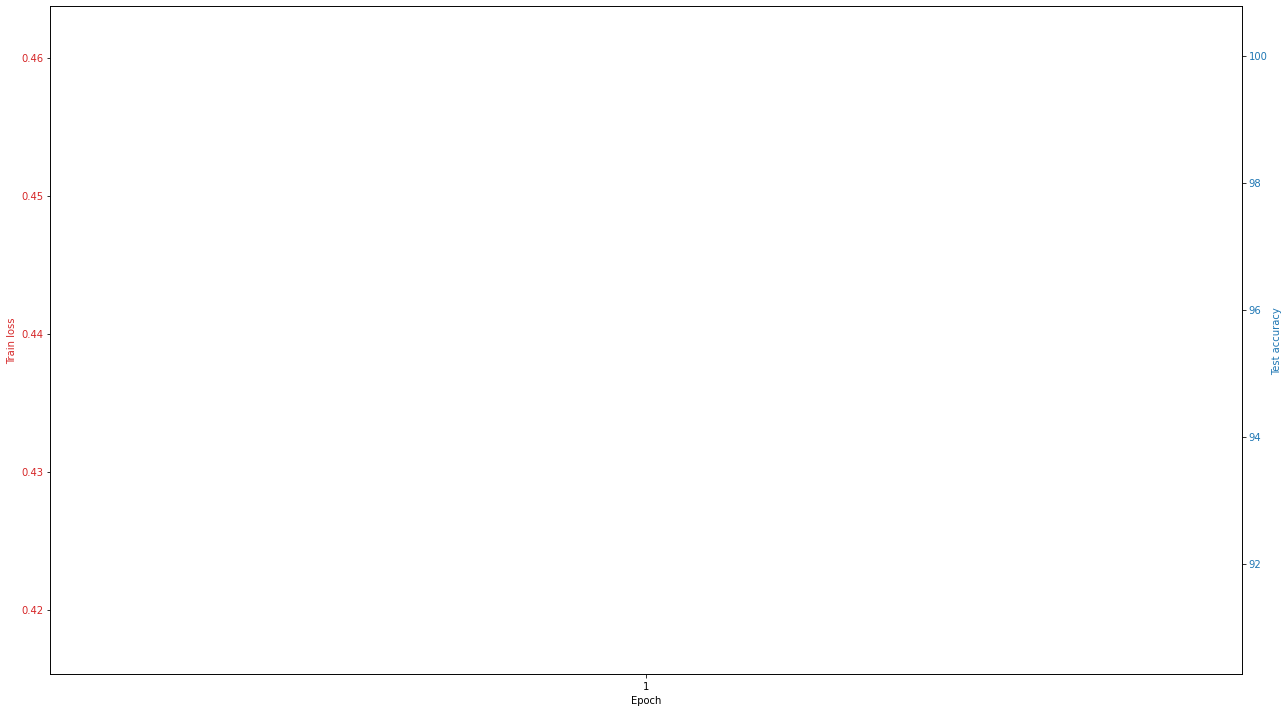

saved model /shares/bulk/earapidis/dev/BinarizedNN/saved_models/lenet_5/model_1/epoch_1.pth
Train Epoch: 2 [0/60000 (0%)]	Loss: 0.245834
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.162551
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.139209
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.240102
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.129654
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.155792
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.183302
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.179208
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.194417
Train Epoch: 2 [57600/60000 (96%)]	Loss: 0.082385

Test set: Average loss: 0.0002, Accuracy: 9499/10000 (95%)

[0.24583381414413452, 0.15876950323581696, 0.3656987249851227, 0.24650762975215912, 0.27395209670066833, 0.28857022523880005, 0.2115720957517624, 0.17082208395004272, 0.24765199422836304, 0.32010790705680847, 0.2949371337890625, 0.2473295032978058, 0.2107412964105606, 0.32855546474456787, 0.36081936955451965, 0.2588525414466858, 0.2927710711956024, 0.

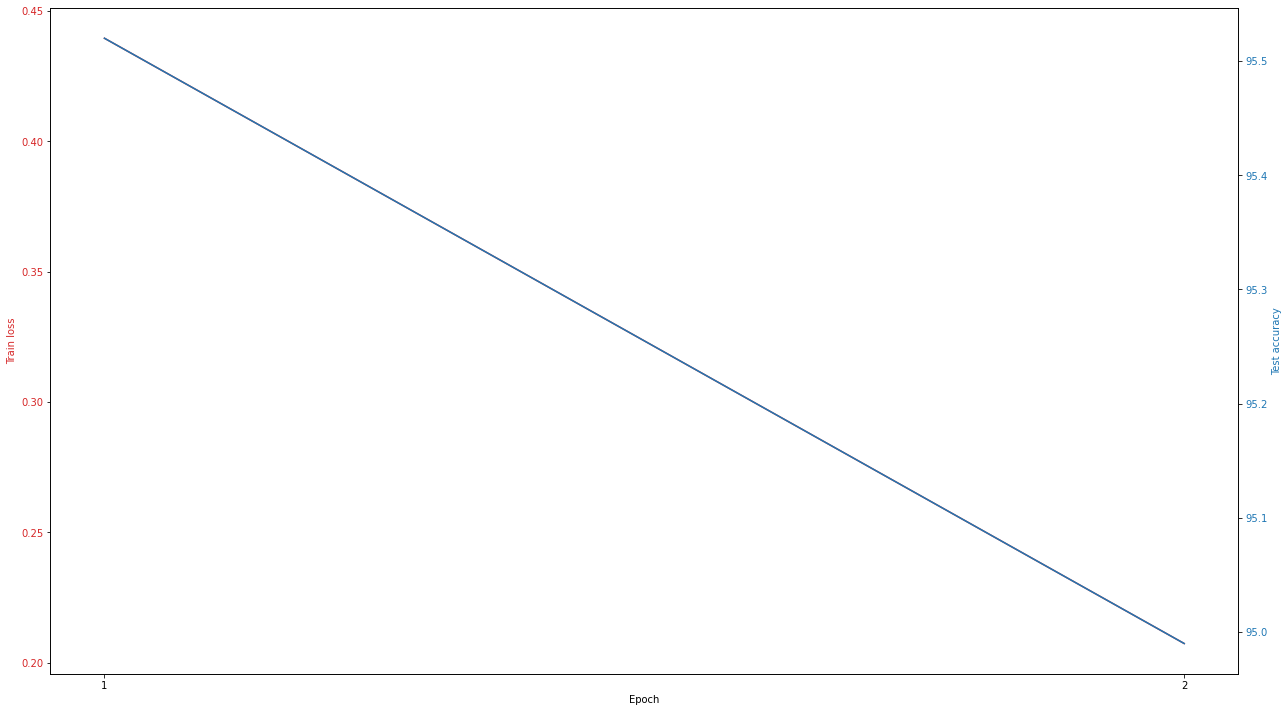

saved model /shares/bulk/earapidis/dev/BinarizedNN/saved_models/lenet_5/model_1/epoch_2.pth
Train Epoch: 3 [0/60000 (0%)]	Loss: 0.276706
Train Epoch: 3 [6400/60000 (11%)]	Loss: 0.169072
Train Epoch: 3 [12800/60000 (21%)]	Loss: 0.088079
Train Epoch: 3 [19200/60000 (32%)]	Loss: 0.072822
Train Epoch: 3 [25600/60000 (43%)]	Loss: 0.112591
Train Epoch: 3 [32000/60000 (53%)]	Loss: 0.239286
Train Epoch: 3 [38400/60000 (64%)]	Loss: 0.234895
Train Epoch: 3 [44800/60000 (75%)]	Loss: 0.068949
Train Epoch: 3 [51200/60000 (85%)]	Loss: 0.096786
Train Epoch: 3 [57600/60000 (96%)]	Loss: 0.115840

Test set: Average loss: 0.0001, Accuracy: 9693/10000 (97%)

[0.2767059803009033, 0.23222488164901733, 0.11071009933948517, 0.27839431166648865, 0.11141692847013474, 0.16935908794403076, 0.1847105771303177, 0.12884090840816498, 0.10425906628370285, 0.21389032900333405, 0.1391265094280243, 0.23328422009944916, 0.09538533538579941, 0.0961175411939621, 0.19125331938266754, 0.19669848680496216, 0.12604019045829773,

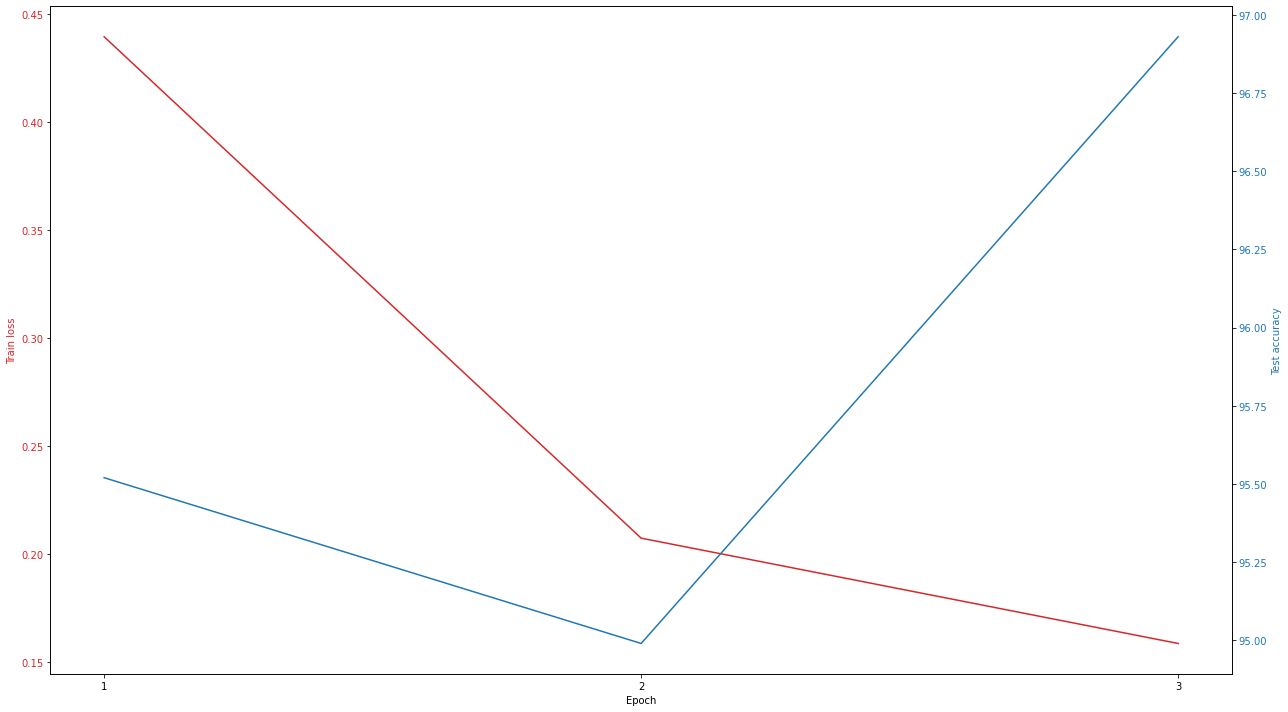

saved model /shares/bulk/earapidis/dev/BinarizedNN/saved_models/lenet_5/model_1/epoch_3.pth
Train Epoch: 4 [0/60000 (0%)]	Loss: 0.055831
Train Epoch: 4 [6400/60000 (11%)]	Loss: 0.234986
Train Epoch: 4 [12800/60000 (21%)]	Loss: 0.172094
Train Epoch: 4 [19200/60000 (32%)]	Loss: 0.152828
Train Epoch: 4 [25600/60000 (43%)]	Loss: 0.218447
Train Epoch: 4 [32000/60000 (53%)]	Loss: 0.236266
Train Epoch: 4 [38400/60000 (64%)]	Loss: 0.121817
Train Epoch: 4 [44800/60000 (75%)]	Loss: 0.084255
Train Epoch: 4 [51200/60000 (85%)]	Loss: 0.155449
Train Epoch: 4 [57600/60000 (96%)]	Loss: 0.095679

Test set: Average loss: 0.0001, Accuracy: 9757/10000 (98%)

[0.05583103373646736, 0.14356428384780884, 0.32968419790267944, 0.11281394958496094, 0.4456495940685272, 0.16494983434677124, 0.21758127212524414, 0.08139128983020782, 0.10503708571195602, 0.11543519794940948, 0.0755142793059349, 0.07775723934173584, 0.24353910982608795, 0.15156030654907227, 0.08101537823677063, 0.1479257196187973, 0.05610577762126922

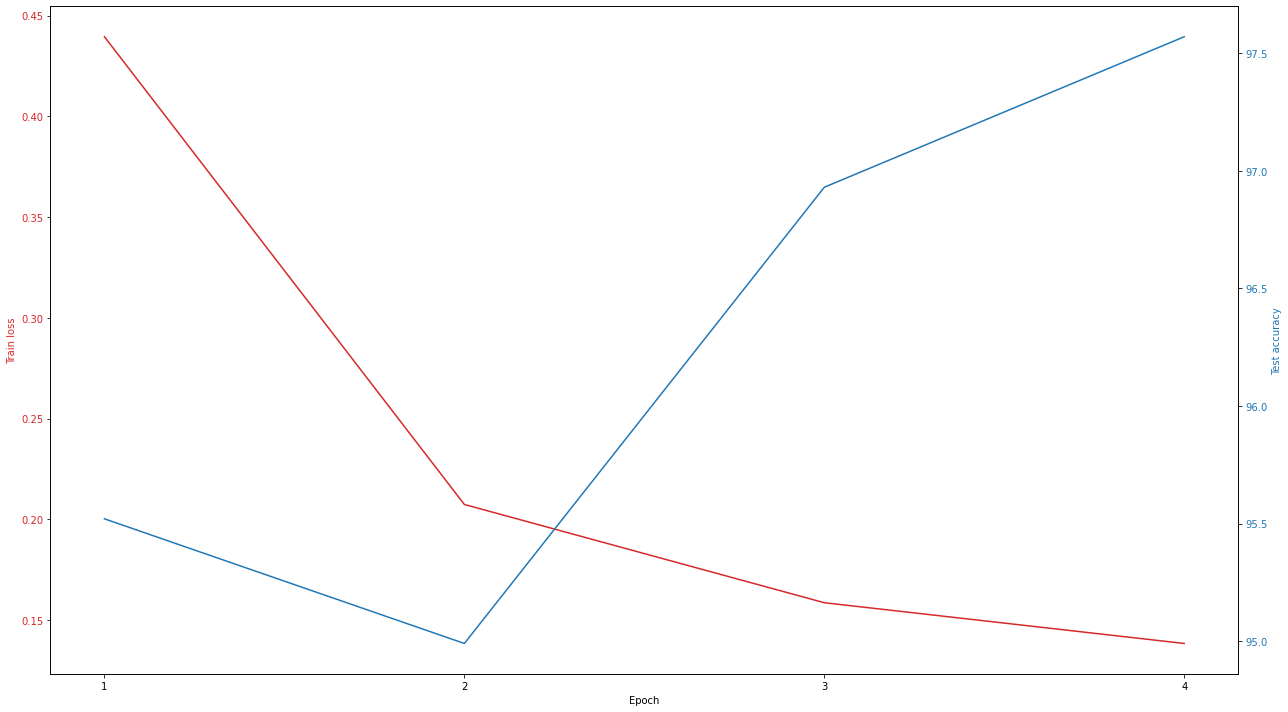

saved model /shares/bulk/earapidis/dev/BinarizedNN/saved_models/lenet_5/model_1/epoch_4.pth
Train Epoch: 5 [0/60000 (0%)]	Loss: 0.206213
Train Epoch: 5 [6400/60000 (11%)]	Loss: 0.034533
Train Epoch: 5 [12800/60000 (21%)]	Loss: 0.177700
Train Epoch: 5 [19200/60000 (32%)]	Loss: 0.109555
Train Epoch: 5 [25600/60000 (43%)]	Loss: 0.030812
Train Epoch: 5 [32000/60000 (53%)]	Loss: 0.073088
Train Epoch: 5 [38400/60000 (64%)]	Loss: 0.135352
Train Epoch: 5 [44800/60000 (75%)]	Loss: 0.038691
Train Epoch: 5 [51200/60000 (85%)]	Loss: 0.077552
Train Epoch: 5 [57600/60000 (96%)]	Loss: 0.127068

Test set: Average loss: 0.0001, Accuracy: 9745/10000 (97%)

[0.20621314644813538, 0.0878787636756897, 0.10628680884838104, 0.059320371598005295, 0.11901356279850006, 0.10216043144464493, 0.1322610229253769, 0.03535088896751404, 0.15217441320419312, 0.0709008276462555, 0.17100979387760162, 0.33304327726364136, 0.11634037643671036, 0.15654698014259338, 0.132155641913414, 0.15032821893692017, 0.053176697343587875

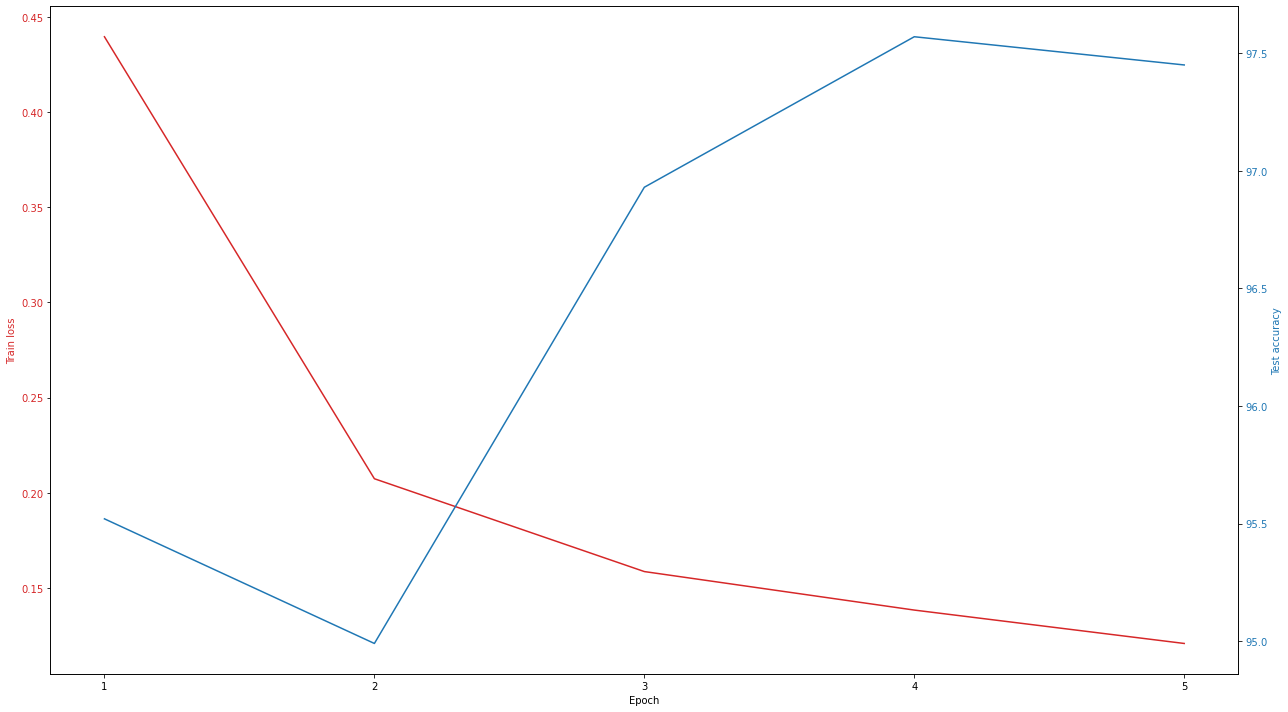

saved model /shares/bulk/earapidis/dev/BinarizedNN/saved_models/lenet_5/model_1/epoch_5.pth
Train Epoch: 6 [0/60000 (0%)]	Loss: 0.089630
Train Epoch: 6 [6400/60000 (11%)]	Loss: 0.118015
Train Epoch: 6 [12800/60000 (21%)]	Loss: 0.048047
Train Epoch: 6 [19200/60000 (32%)]	Loss: 0.138695
Train Epoch: 6 [25600/60000 (43%)]	Loss: 0.100101
Train Epoch: 6 [32000/60000 (53%)]	Loss: 0.110742
Train Epoch: 6 [38400/60000 (64%)]	Loss: 0.225325
Train Epoch: 6 [44800/60000 (75%)]	Loss: 0.174273
Train Epoch: 6 [51200/60000 (85%)]	Loss: 0.102552
Train Epoch: 6 [57600/60000 (96%)]	Loss: 0.017910

Test set: Average loss: 0.0001, Accuracy: 9669/10000 (97%)

[0.08962986618280411, 0.11428476125001907, 0.10512633621692657, 0.039645254611968994, 0.17757169902324677, 0.15230965614318848, 0.050929684191942215, 0.1982135772705078, 0.14448301494121552, 0.14228388667106628, 0.1457703709602356, 0.13283085823059082, 0.028665900230407715, 0.14601846039295197, 0.11885388940572739, 0.0389690063893795, 0.09457018971443

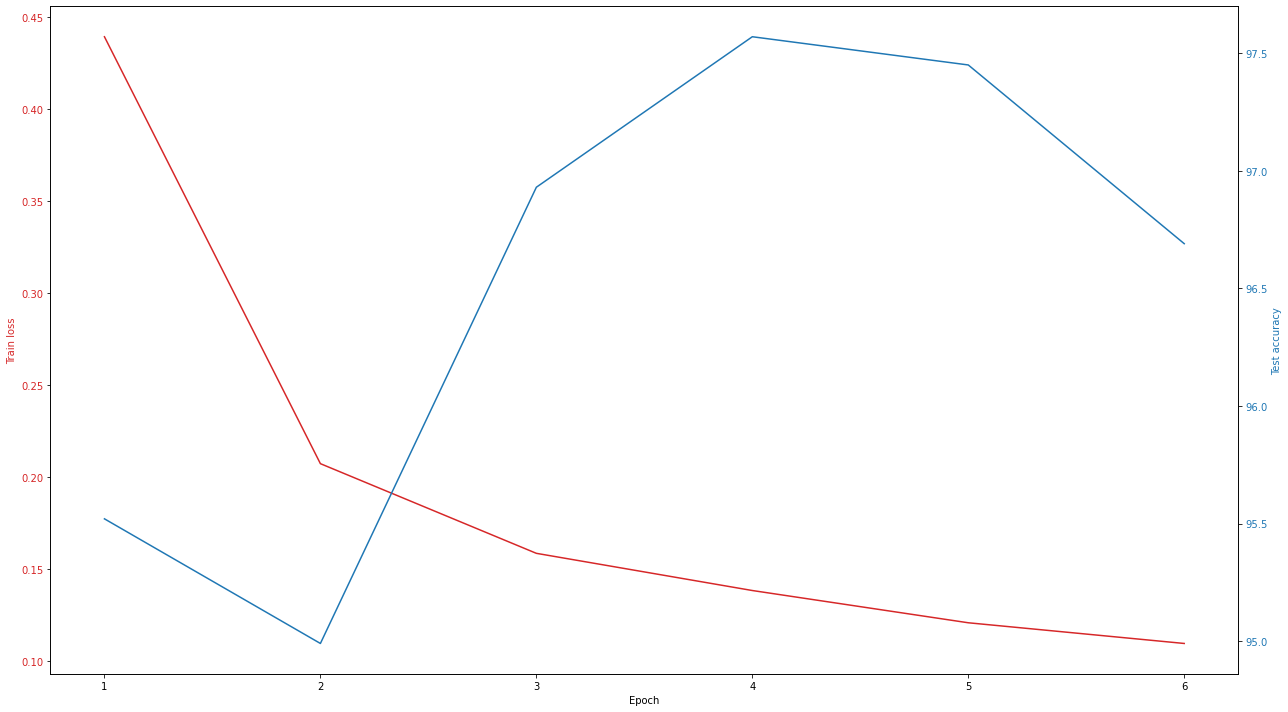

saved model /shares/bulk/earapidis/dev/BinarizedNN/saved_models/lenet_5/model_1/epoch_6.pth
Train Epoch: 7 [0/60000 (0%)]	Loss: 0.207016
Train Epoch: 7 [6400/60000 (11%)]	Loss: 0.170717
Train Epoch: 7 [12800/60000 (21%)]	Loss: 0.024841
Train Epoch: 7 [19200/60000 (32%)]	Loss: 0.081772
Train Epoch: 7 [25600/60000 (43%)]	Loss: 0.104003
Train Epoch: 7 [32000/60000 (53%)]	Loss: 0.059037
Train Epoch: 7 [38400/60000 (64%)]	Loss: 0.124672
Train Epoch: 7 [44800/60000 (75%)]	Loss: 0.033911
Train Epoch: 7 [51200/60000 (85%)]	Loss: 0.051688
Train Epoch: 7 [57600/60000 (96%)]	Loss: 0.224088

Test set: Average loss: 0.0001, Accuracy: 9720/10000 (97%)

[0.20701585710048676, 0.059035524725914, 0.020600326359272003, 0.1304236799478531, 0.11944495141506195, 0.06566563993692398, 0.16018064320087433, 0.1015600934624672, 0.13930752873420715, 0.12613646686077118, 0.12511678040027618, 0.13524110615253448, 0.09141674637794495, 0.0254889577627182, 0.09797143191099167, 0.04656408727169037, 0.18576271831989288,

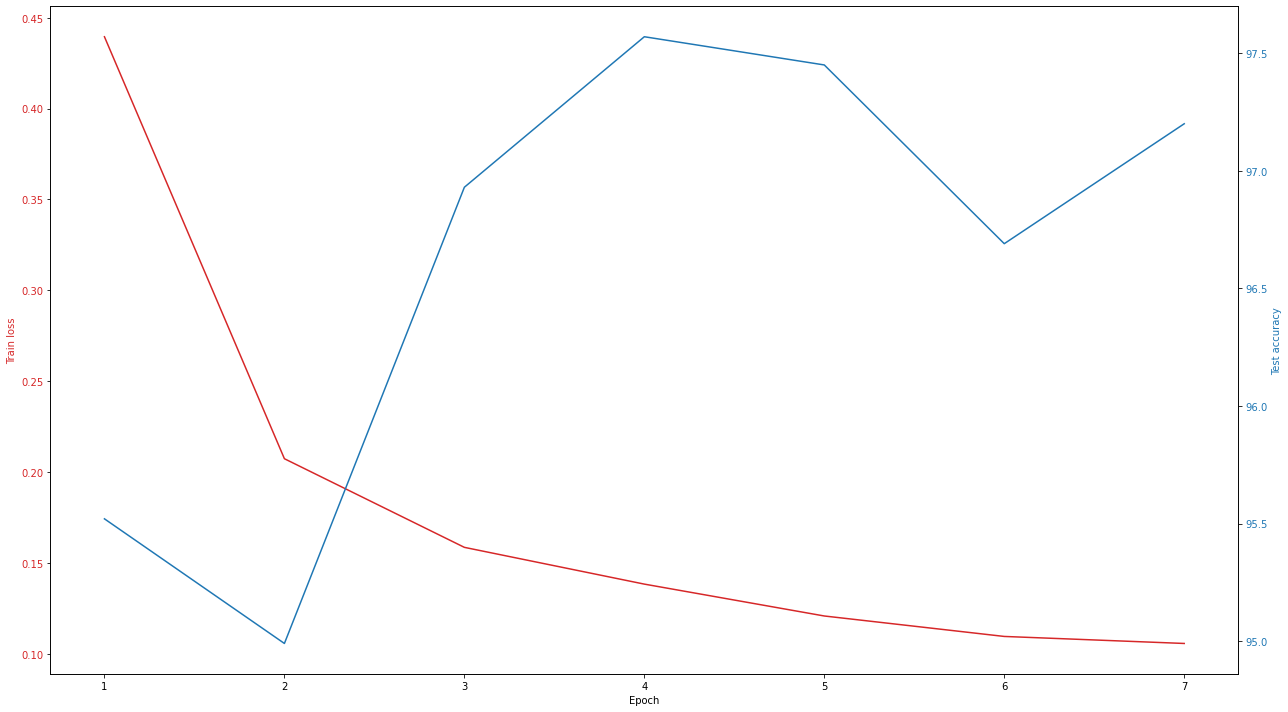

saved model /shares/bulk/earapidis/dev/BinarizedNN/saved_models/lenet_5/model_1/epoch_7.pth
Train Epoch: 8 [0/60000 (0%)]	Loss: 0.156697
Train Epoch: 8 [6400/60000 (11%)]	Loss: 0.107813
Train Epoch: 8 [12800/60000 (21%)]	Loss: 0.117933
Train Epoch: 8 [19200/60000 (32%)]	Loss: 0.053394
Train Epoch: 8 [25600/60000 (43%)]	Loss: 0.079278
Train Epoch: 8 [32000/60000 (53%)]	Loss: 0.022662
Train Epoch: 8 [38400/60000 (64%)]	Loss: 0.146232
Train Epoch: 8 [44800/60000 (75%)]	Loss: 0.044569
Train Epoch: 8 [51200/60000 (85%)]	Loss: 0.258544
Train Epoch: 8 [57600/60000 (96%)]	Loss: 0.087657

Test set: Average loss: 0.0001, Accuracy: 9780/10000 (98%)

[0.15669670701026917, 0.040879830718040466, 0.06841936707496643, 0.05355268716812134, 0.07303813099861145, 0.1671825647354126, 0.07293349504470825, 0.0551396906375885, 0.06358972191810608, 0.2277788370847702, 0.11514224112033844, 0.08065059781074524, 0.1803412288427353, 0.2090311497449875, 0.0884888619184494, 0.08207869529724121, 0.039118438959121704,

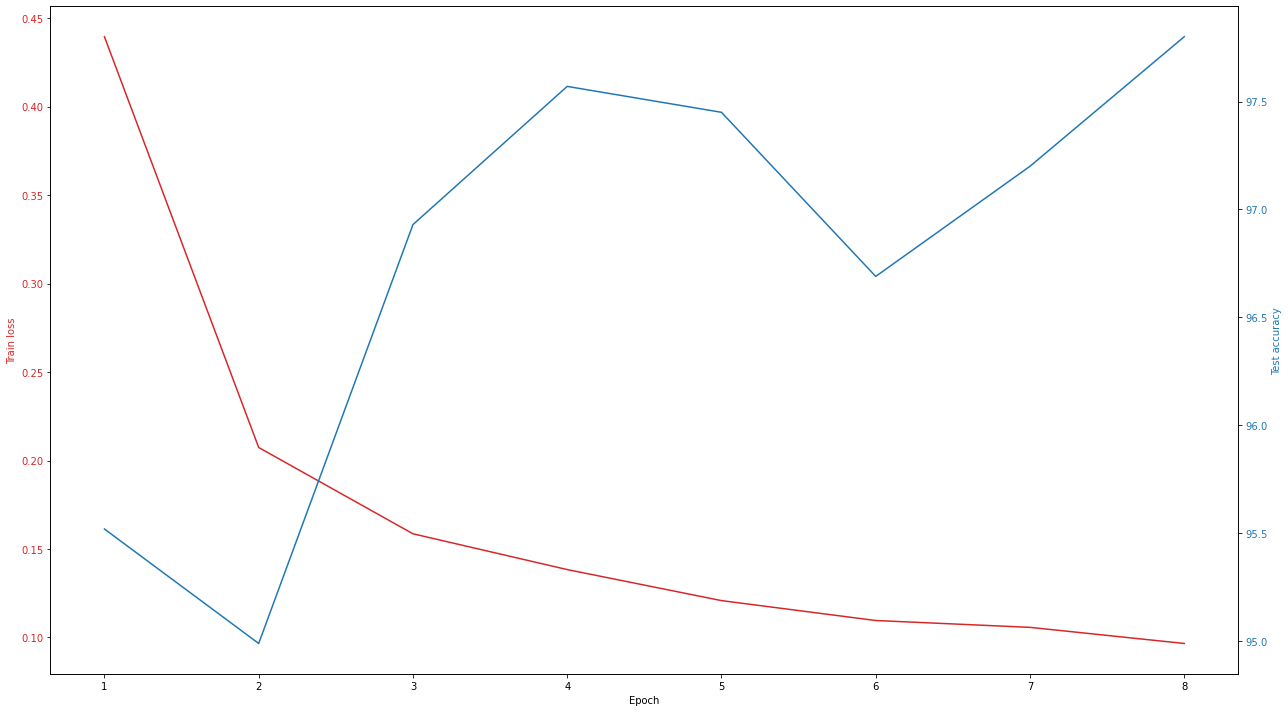

saved model /shares/bulk/earapidis/dev/BinarizedNN/saved_models/lenet_5/model_1/epoch_8.pth
Train Epoch: 9 [0/60000 (0%)]	Loss: 0.029723
Train Epoch: 9 [6400/60000 (11%)]	Loss: 0.034427
Train Epoch: 9 [12800/60000 (21%)]	Loss: 0.199224
Train Epoch: 9 [19200/60000 (32%)]	Loss: 0.312186
Train Epoch: 9 [25600/60000 (43%)]	Loss: 0.013949
Train Epoch: 9 [32000/60000 (53%)]	Loss: 0.200267
Train Epoch: 9 [38400/60000 (64%)]	Loss: 0.012766
Train Epoch: 9 [44800/60000 (75%)]	Loss: 0.079875
Train Epoch: 9 [51200/60000 (85%)]	Loss: 0.255411
Train Epoch: 9 [57600/60000 (96%)]	Loss: 0.044034

Test set: Average loss: 0.0009, Accuracy: 7021/10000 (70%)

[0.0297231487929821, 0.09549648314714432, 0.10362782329320908, 0.05027786269783974, 0.0448543019592762, 0.08612523972988129, 0.12159541249275208, 0.026254476979374886, 0.1271456480026245, 0.057462818920612335, 0.13072696328163147, 0.1085498183965683, 0.03543999418616295, 0.05276870355010033, 0.05987878143787384, 0.08590956032276154, 0.1023699492216110

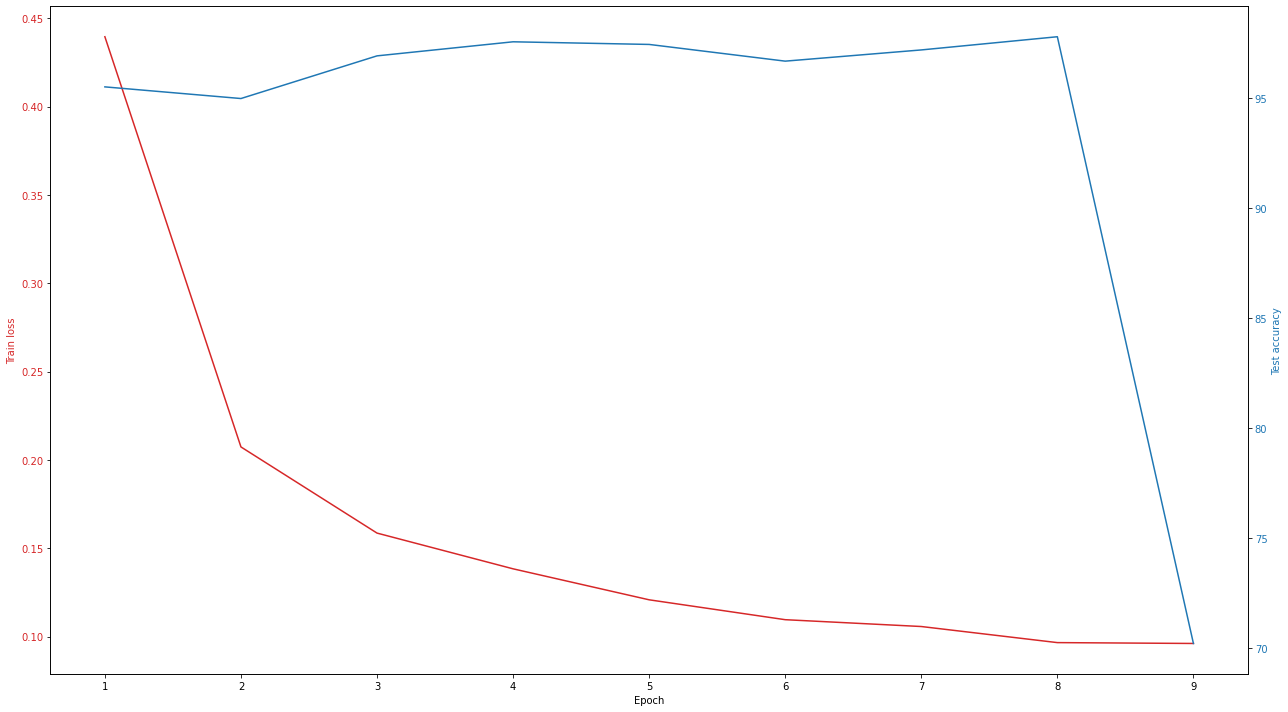

saved model /shares/bulk/earapidis/dev/BinarizedNN/saved_models/lenet_5/model_1/epoch_9.pth
Train Epoch: 10 [0/60000 (0%)]	Loss: 0.038632
Train Epoch: 10 [6400/60000 (11%)]	Loss: 0.123905
Train Epoch: 10 [12800/60000 (21%)]	Loss: 0.075821
Train Epoch: 10 [19200/60000 (32%)]	Loss: 0.085835
Train Epoch: 10 [25600/60000 (43%)]	Loss: 0.023284
Train Epoch: 10 [32000/60000 (53%)]	Loss: 0.168897
Train Epoch: 10 [38400/60000 (64%)]	Loss: 0.021305
Train Epoch: 10 [44800/60000 (75%)]	Loss: 0.058474
Train Epoch: 10 [51200/60000 (85%)]	Loss: 0.081200
Train Epoch: 10 [57600/60000 (96%)]	Loss: 0.040448

Test set: Average loss: 0.0002, Accuracy: 9507/10000 (95%)

[0.03863203898072243, 0.10059361159801483, 0.10371758788824081, 0.08096329867839813, 0.01774044707417488, 0.01844462938606739, 0.04344364255666733, 0.28146836161613464, 0.12207198888063431, 0.09509135782718658, 0.10258050262928009, 0.2671334445476532, 0.1186690479516983, 0.046781234443187714, 0.025851815938949585, 0.06879489868879318, 0.0580

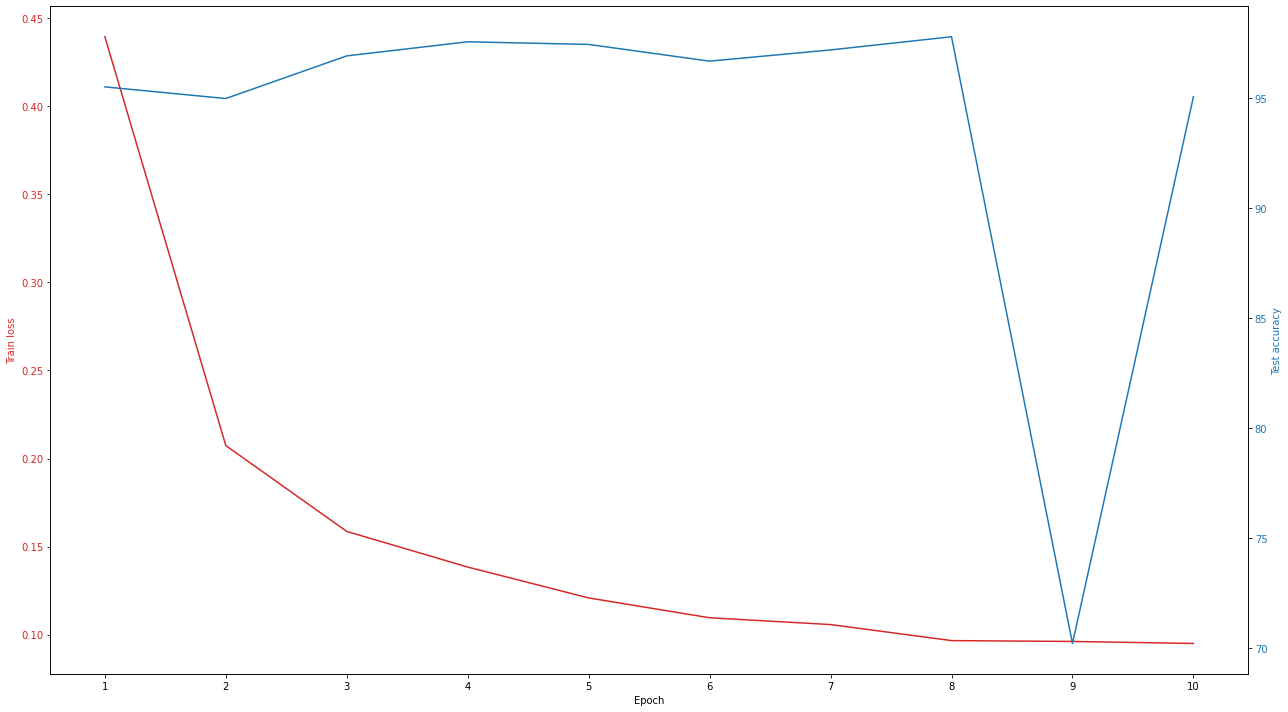

saved model /shares/bulk/earapidis/dev/BinarizedNN/saved_models/lenet_5/model_1/epoch_10.pth
Train Epoch: 11 [0/60000 (0%)]	Loss: 0.036881
Train Epoch: 11 [6400/60000 (11%)]	Loss: 0.055347
Train Epoch: 11 [12800/60000 (21%)]	Loss: 0.055154
Train Epoch: 11 [19200/60000 (32%)]	Loss: 0.142477
Train Epoch: 11 [25600/60000 (43%)]	Loss: 0.084799
Train Epoch: 11 [32000/60000 (53%)]	Loss: 0.032909
Train Epoch: 11 [38400/60000 (64%)]	Loss: 0.086326
Train Epoch: 11 [44800/60000 (75%)]	Loss: 0.227901
Train Epoch: 11 [51200/60000 (85%)]	Loss: 0.029788
Train Epoch: 11 [57600/60000 (96%)]	Loss: 0.014306

Test set: Average loss: 0.0001, Accuracy: 9808/10000 (98%)

[0.036880843341350555, 0.04903843626379967, 0.09720931202173233, 0.05947146192193031, 0.05663694441318512, 0.0731346383690834, 0.0327281579375267, 0.1309342235326767, 0.04312707483768463, 0.15202732384204865, 0.14147412776947021, 0.0260312557220459, 0.09051787108182907, 0.12218120694160461, 0.154440239071846, 0.10222302377223969, 0.04768288

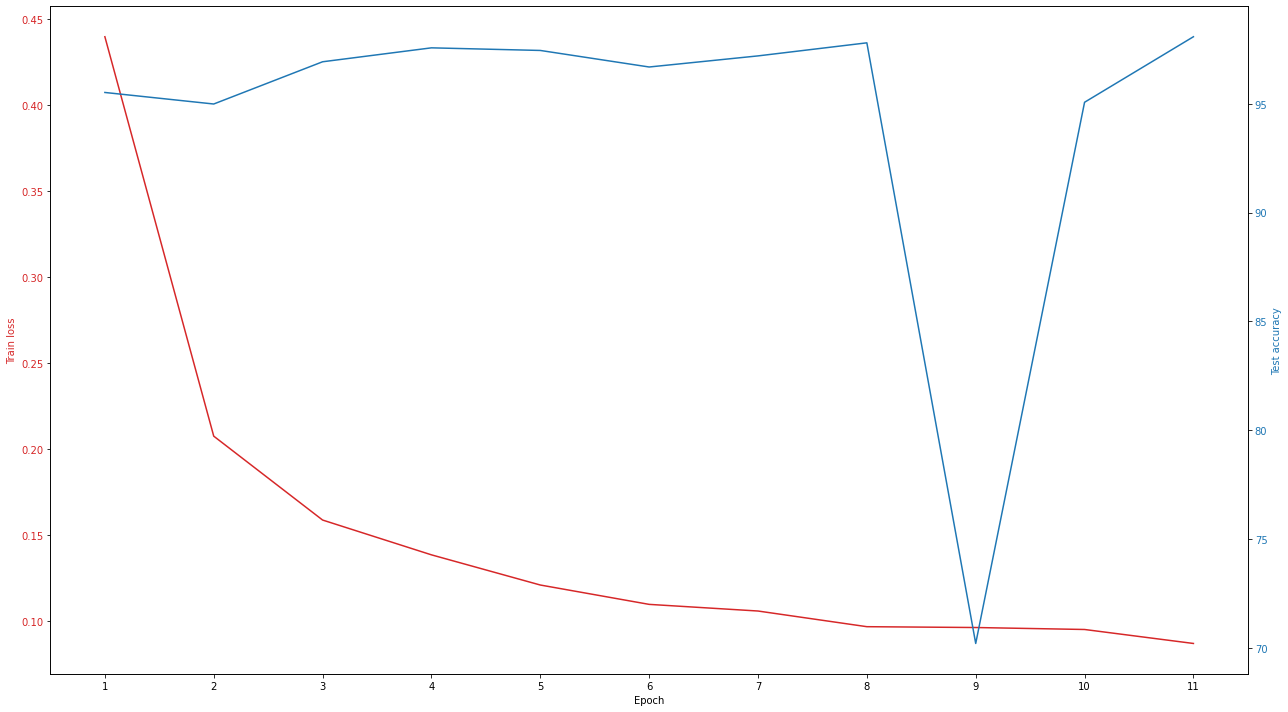

saved model /shares/bulk/earapidis/dev/BinarizedNN/saved_models/lenet_5/model_1/epoch_11.pth
Train Epoch: 12 [0/60000 (0%)]	Loss: 0.031588
Train Epoch: 12 [6400/60000 (11%)]	Loss: 0.055685
Train Epoch: 12 [12800/60000 (21%)]	Loss: 0.058029
Train Epoch: 12 [19200/60000 (32%)]	Loss: 0.030881
Train Epoch: 12 [25600/60000 (43%)]	Loss: 0.130754
Train Epoch: 12 [32000/60000 (53%)]	Loss: 0.042246
Train Epoch: 12 [38400/60000 (64%)]	Loss: 0.155866
Train Epoch: 12 [44800/60000 (75%)]	Loss: 0.096306
Train Epoch: 12 [51200/60000 (85%)]	Loss: 0.049525
Train Epoch: 12 [57600/60000 (96%)]	Loss: 0.099326

Test set: Average loss: 0.0009, Accuracy: 7109/10000 (71%)

[0.03158801421523094, 0.042274314910173416, 0.1039174273610115, 0.005538781173527241, 0.05168502405285835, 0.13880938291549683, 0.09968136996030807, 0.06600110977888107, 0.18107767403125763, 0.1253136843442917, 0.04420430213212967, 0.08657341450452805, 0.14147378504276276, 0.26072418689727783, 0.04854653775691986, 0.19125233590602875, 0.031

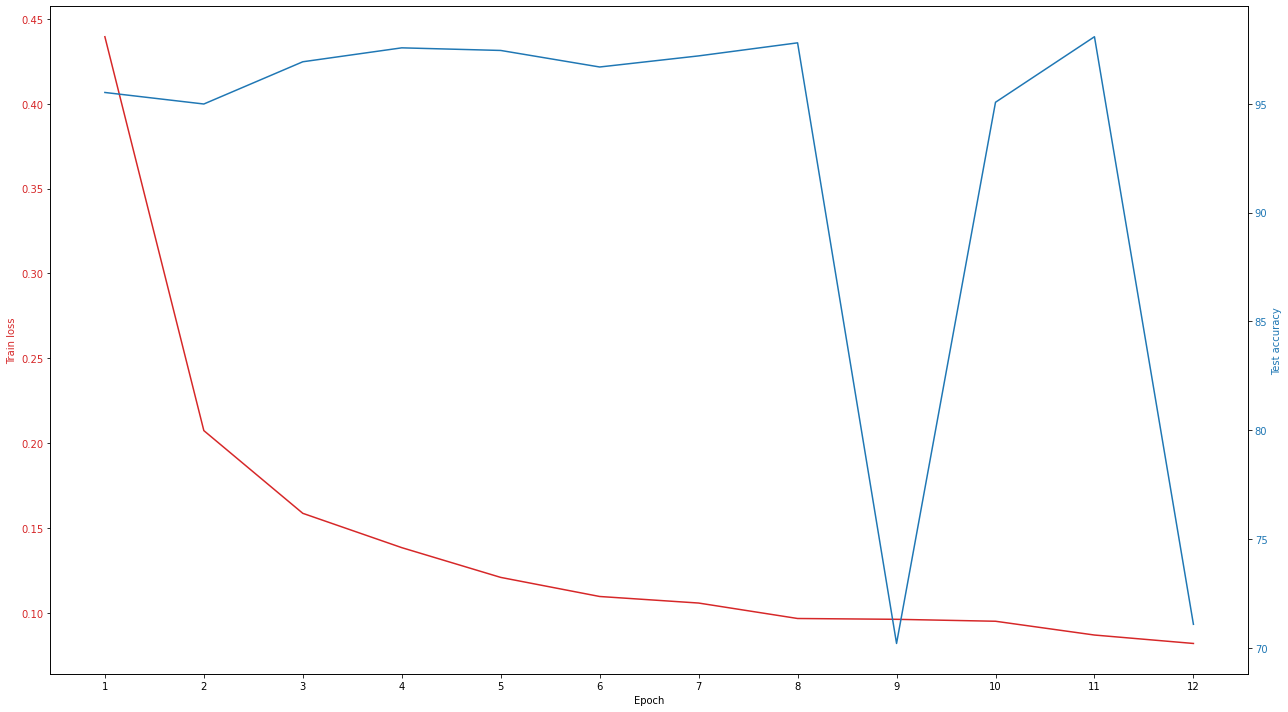

saved model /shares/bulk/earapidis/dev/BinarizedNN/saved_models/lenet_5/model_1/epoch_12.pth
Train Epoch: 13 [0/60000 (0%)]	Loss: 0.157697
Train Epoch: 13 [6400/60000 (11%)]	Loss: 0.019945
Train Epoch: 13 [12800/60000 (21%)]	Loss: 0.069249
Train Epoch: 13 [19200/60000 (32%)]	Loss: 0.163280
Train Epoch: 13 [25600/60000 (43%)]	Loss: 0.009582
Train Epoch: 13 [32000/60000 (53%)]	Loss: 0.115959
Train Epoch: 13 [38400/60000 (64%)]	Loss: 0.104230
Train Epoch: 13 [44800/60000 (75%)]	Loss: 0.076518
Train Epoch: 13 [51200/60000 (85%)]	Loss: 0.045735
Train Epoch: 13 [57600/60000 (96%)]	Loss: 0.079623

Test set: Average loss: 0.0001, Accuracy: 9756/10000 (98%)

[0.15769736468791962, 0.01627975143492222, 0.021404532715678215, 0.06502650678157806, 0.015277479775249958, 0.04890243336558342, 0.044438522309064865, 0.0192857775837183, 0.08303824812173843, 0.10775066912174225, 0.012275094166398048, 0.20865251123905182, 0.04380771517753601, 0.008914033882319927, 0.08666783571243286, 0.038118474185466766, 

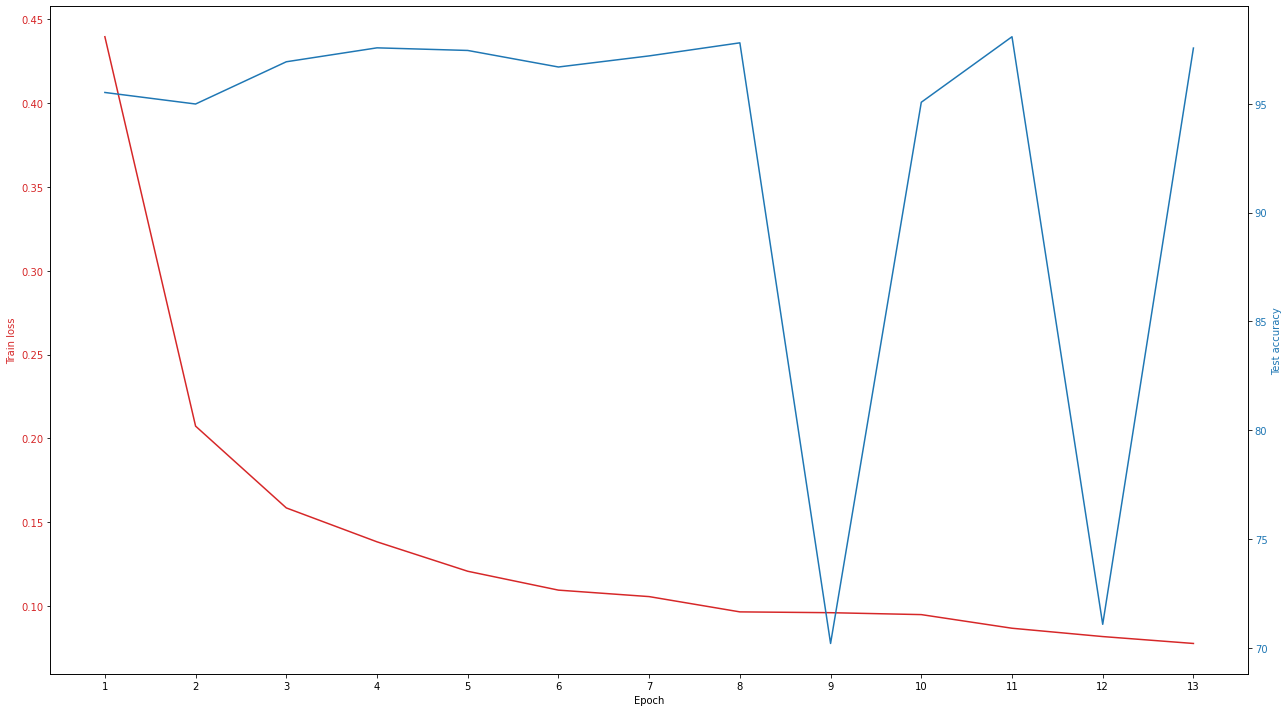

saved model /shares/bulk/earapidis/dev/BinarizedNN/saved_models/lenet_5/model_1/epoch_13.pth
Train Epoch: 14 [0/60000 (0%)]	Loss: 0.182601
Train Epoch: 14 [6400/60000 (11%)]	Loss: 0.150174
Train Epoch: 14 [12800/60000 (21%)]	Loss: 0.151601
Train Epoch: 14 [19200/60000 (32%)]	Loss: 0.079577
Train Epoch: 14 [25600/60000 (43%)]	Loss: 0.026509
Train Epoch: 14 [32000/60000 (53%)]	Loss: 0.135006
Train Epoch: 14 [38400/60000 (64%)]	Loss: 0.057272
Train Epoch: 14 [44800/60000 (75%)]	Loss: 0.324821
Train Epoch: 14 [51200/60000 (85%)]	Loss: 0.111819
Train Epoch: 14 [57600/60000 (96%)]	Loss: 0.247794

Test set: Average loss: 0.0012, Accuracy: 6619/10000 (66%)

[0.18260110914707184, 0.033445071429014206, 0.02654881216585636, 0.10456955432891846, 0.04087507724761963, 0.06789083778858185, 0.242341548204422, 0.025468626990914345, 0.16954855620861053, 0.12597455084323883, 0.13913016021251678, 0.089775450527668, 0.014773376286029816, 0.07511182874441147, 0.05721273645758629, 0.05243231728672981, 0.0993

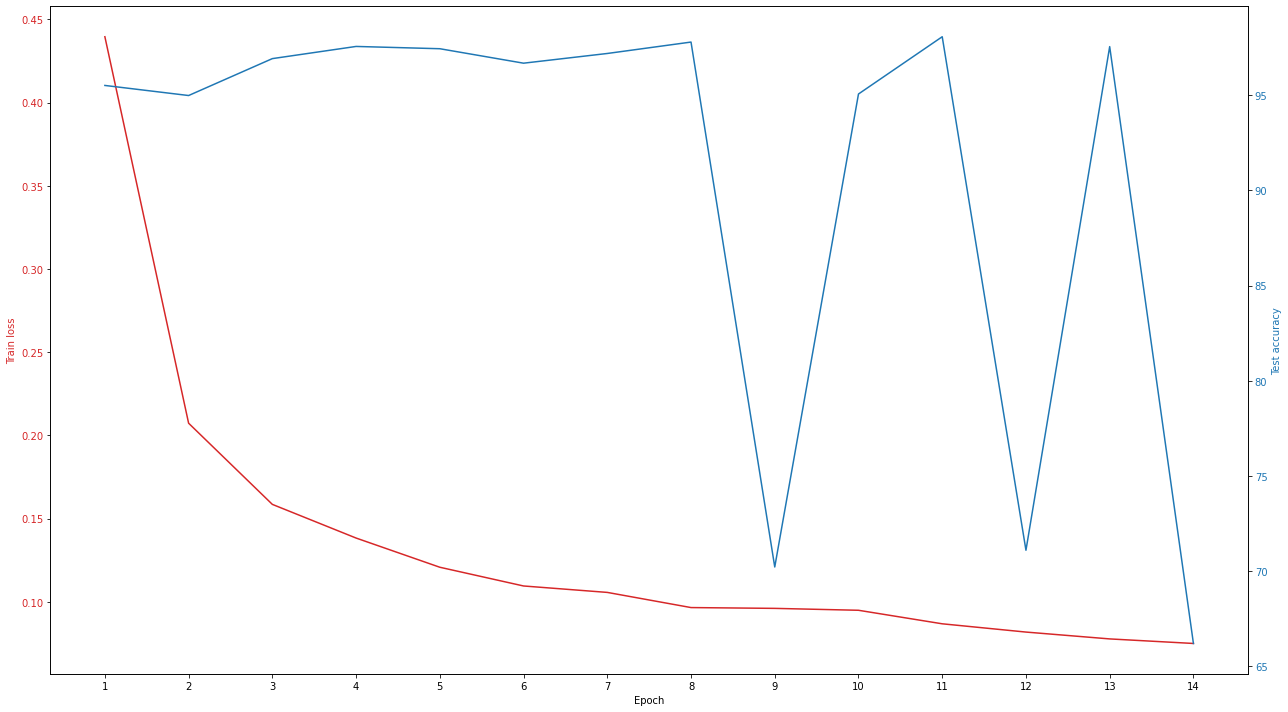

saved model /shares/bulk/earapidis/dev/BinarizedNN/saved_models/lenet_5/model_1/epoch_14.pth
Train Epoch: 15 [0/60000 (0%)]	Loss: 0.030306
Train Epoch: 15 [6400/60000 (11%)]	Loss: 0.202806
Train Epoch: 15 [12800/60000 (21%)]	Loss: 0.094119
Train Epoch: 15 [19200/60000 (32%)]	Loss: 0.047575
Train Epoch: 15 [25600/60000 (43%)]	Loss: 0.017880
Train Epoch: 15 [32000/60000 (53%)]	Loss: 0.005737
Train Epoch: 15 [38400/60000 (64%)]	Loss: 0.113914
Train Epoch: 15 [44800/60000 (75%)]	Loss: 0.051539
Train Epoch: 15 [51200/60000 (85%)]	Loss: 0.079386
Train Epoch: 15 [57600/60000 (96%)]	Loss: 0.025716

Test set: Average loss: 0.0001, Accuracy: 9799/10000 (98%)

[0.03030567616224289, 0.036644164472818375, 0.09660205990076065, 0.028513628989458084, 0.021235324442386627, 0.07248128205537796, 0.05749012157320976, 0.04089833423495293, 0.02896905317902565, 0.030565796419978142, 0.10755214840173721, 0.03317047655582428, 0.1272260844707489, 0.04986349120736122, 0.061764564365148544, 0.0820351243019104, 0.

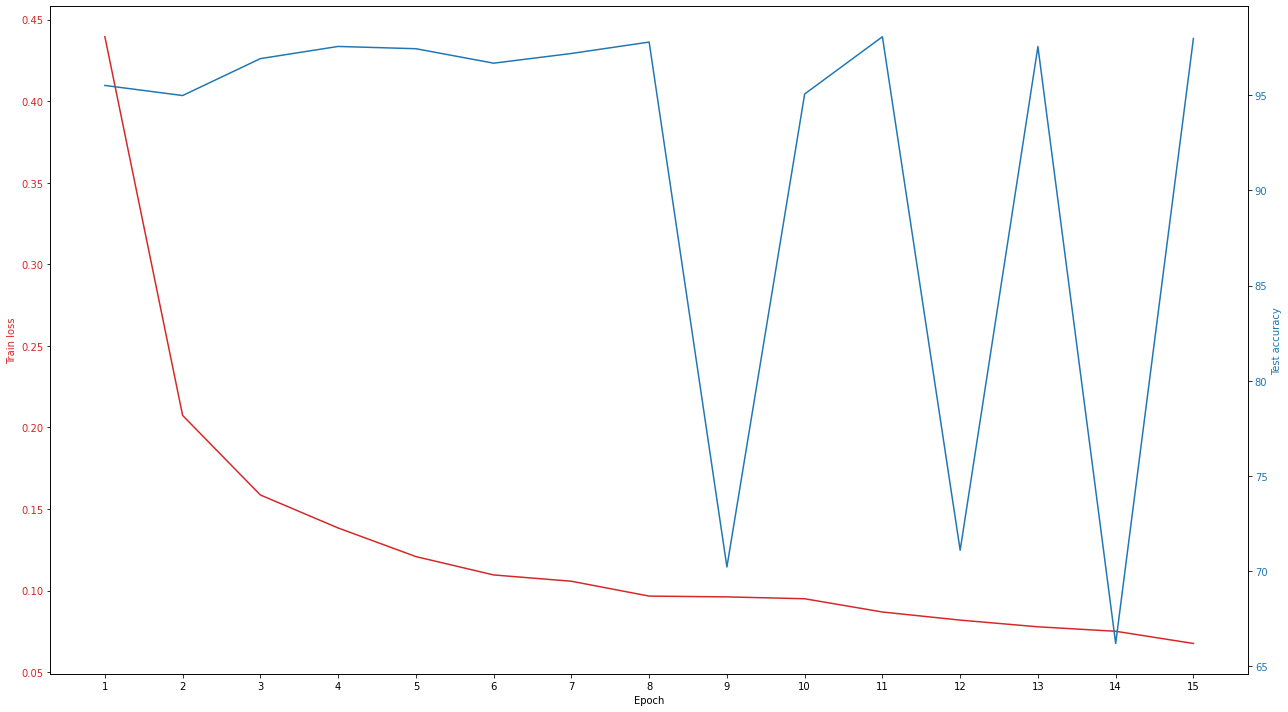

saved model /shares/bulk/earapidis/dev/BinarizedNN/saved_models/lenet_5/model_1/epoch_15.pth
Train Epoch: 16 [0/60000 (0%)]	Loss: 0.025706
Train Epoch: 16 [6400/60000 (11%)]	Loss: 0.009361
Train Epoch: 16 [12800/60000 (21%)]	Loss: 0.177242
Train Epoch: 16 [19200/60000 (32%)]	Loss: 0.037049
Train Epoch: 16 [25600/60000 (43%)]	Loss: 0.057031
Train Epoch: 16 [32000/60000 (53%)]	Loss: 0.012582
Train Epoch: 16 [38400/60000 (64%)]	Loss: 0.037631
Train Epoch: 16 [44800/60000 (75%)]	Loss: 0.012073
Train Epoch: 16 [51200/60000 (85%)]	Loss: 0.021620
Train Epoch: 16 [57600/60000 (96%)]	Loss: 0.093884

Test set: Average loss: 0.0001, Accuracy: 9788/10000 (98%)

[0.02570551447570324, 0.11801528185606003, 0.025249918922781944, 0.07087309658527374, 0.03499268740415573, 0.1424795240163803, 0.11189614236354828, 0.09411492198705673, 0.0979389026761055, 0.03542723506689072, 0.02108933962881565, 0.10809425264596939, 0.026263797655701637, 0.1562792956829071, 0.08730807900428772, 0.18709689378738403, 0.0600

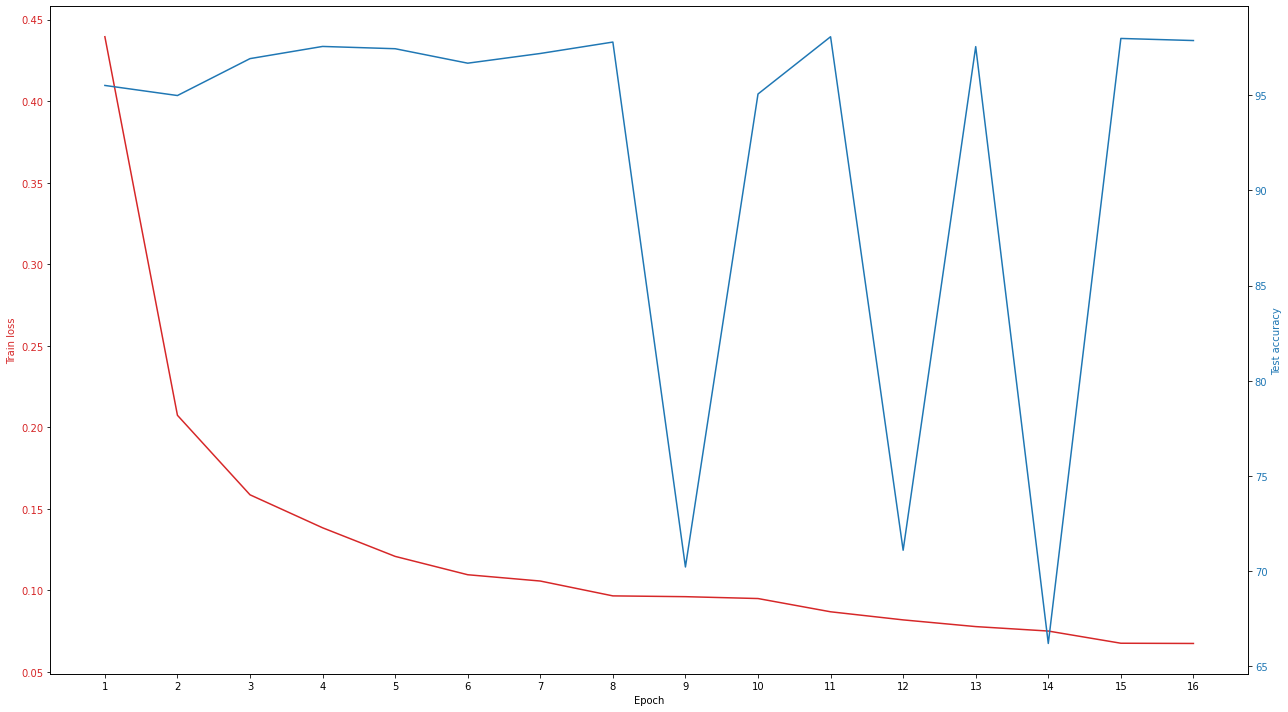

saved model /shares/bulk/earapidis/dev/BinarizedNN/saved_models/lenet_5/model_1/epoch_16.pth
Train Epoch: 17 [0/60000 (0%)]	Loss: 0.056126
Train Epoch: 17 [6400/60000 (11%)]	Loss: 0.107980
Train Epoch: 17 [12800/60000 (21%)]	Loss: 0.061356
Train Epoch: 17 [19200/60000 (32%)]	Loss: 0.035276
Train Epoch: 17 [25600/60000 (43%)]	Loss: 0.011455
Train Epoch: 17 [32000/60000 (53%)]	Loss: 0.019328
Train Epoch: 17 [38400/60000 (64%)]	Loss: 0.026083
Train Epoch: 17 [44800/60000 (75%)]	Loss: 0.159561
Train Epoch: 17 [51200/60000 (85%)]	Loss: 0.050292
Train Epoch: 17 [57600/60000 (96%)]	Loss: 0.070681

Test set: Average loss: 0.0004, Accuracy: 8581/10000 (86%)

[0.05612596496939659, 0.1433536559343338, 0.0650014728307724, 0.06114374101161957, 0.04357609152793884, 0.029009297490119934, 0.09058041870594025, 0.0382242389023304, 0.03219925984740257, 0.012797347269952297, 0.013182119466364384, 0.018029261380434036, 0.11734036356210709, 0.004791593644768, 0.03648886829614639, 0.01904711127281189, 0.0632

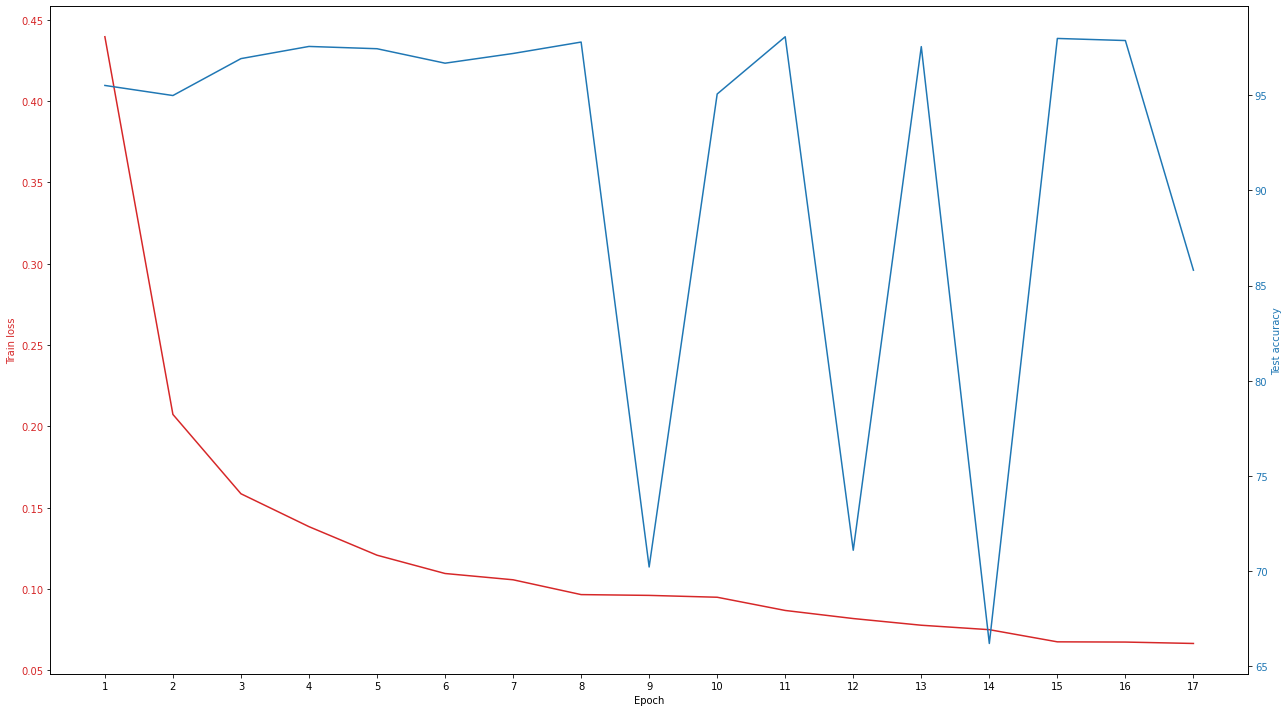

saved model /shares/bulk/earapidis/dev/BinarizedNN/saved_models/lenet_5/model_1/epoch_17.pth
Train Epoch: 18 [0/60000 (0%)]	Loss: 0.070632
Train Epoch: 18 [6400/60000 (11%)]	Loss: 0.123317
Train Epoch: 18 [12800/60000 (21%)]	Loss: 0.006437
Train Epoch: 18 [19200/60000 (32%)]	Loss: 0.027189
Train Epoch: 18 [25600/60000 (43%)]	Loss: 0.053295
Train Epoch: 18 [32000/60000 (53%)]	Loss: 0.162578
Train Epoch: 18 [38400/60000 (64%)]	Loss: 0.033054
Train Epoch: 18 [44800/60000 (75%)]	Loss: 0.022706
Train Epoch: 18 [51200/60000 (85%)]	Loss: 0.017819
Train Epoch: 18 [57600/60000 (96%)]	Loss: 0.097448

Test set: Average loss: 0.0006, Accuracy: 8050/10000 (80%)

[0.07063204050064087, 0.044127438217401505, 0.04859302565455437, 0.014118184335529804, 0.06392541527748108, 0.025134073570370674, 0.037167988717556, 0.132658913731575, 0.09035884588956833, 0.10835787653923035, 0.060031693428754807, 0.05343294143676758, 0.07151923328638077, 0.02243645302951336, 0.07959285378456116, 0.14642320573329926, 0.035

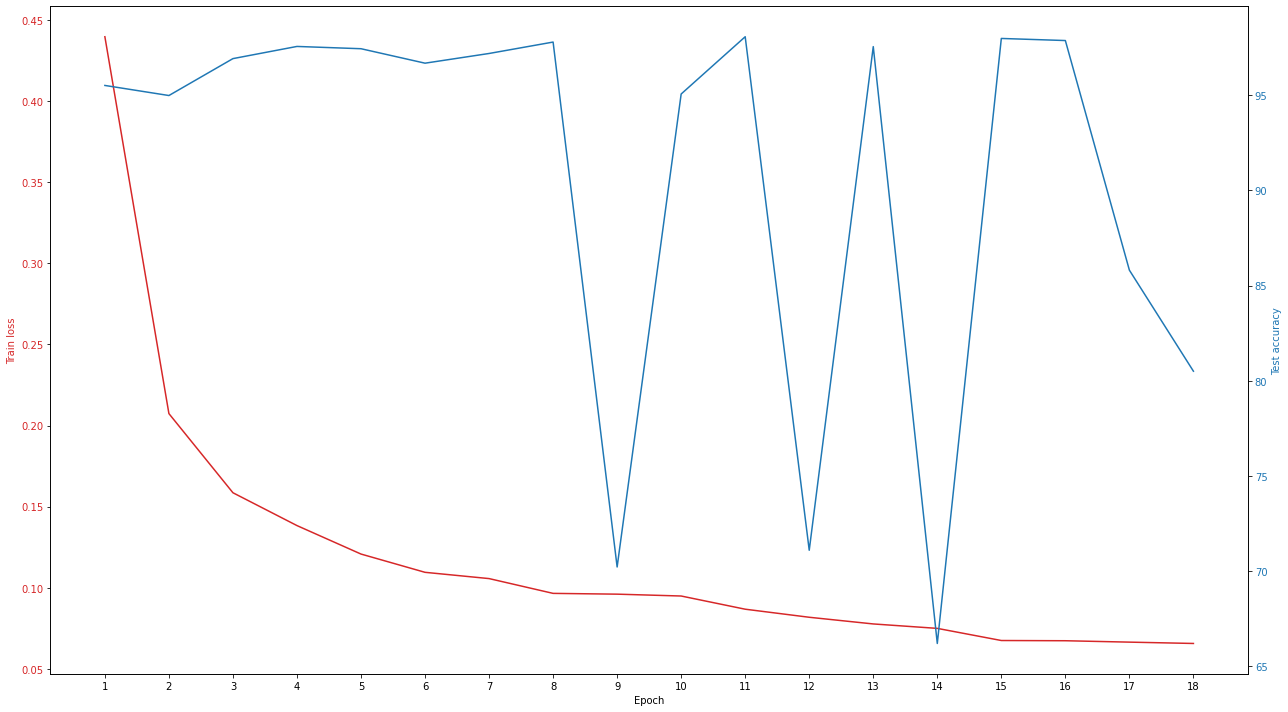

saved model /shares/bulk/earapidis/dev/BinarizedNN/saved_models/lenet_5/model_1/epoch_18.pth
Train Epoch: 19 [0/60000 (0%)]	Loss: 0.043382
Train Epoch: 19 [6400/60000 (11%)]	Loss: 0.017629
Train Epoch: 19 [12800/60000 (21%)]	Loss: 0.021058
Train Epoch: 19 [19200/60000 (32%)]	Loss: 0.102405
Train Epoch: 19 [25600/60000 (43%)]	Loss: 0.011070
Train Epoch: 19 [32000/60000 (53%)]	Loss: 0.086827
Train Epoch: 19 [38400/60000 (64%)]	Loss: 0.109636
Train Epoch: 19 [44800/60000 (75%)]	Loss: 0.016464
Train Epoch: 19 [51200/60000 (85%)]	Loss: 0.010309
Train Epoch: 19 [57600/60000 (96%)]	Loss: 0.069989

Test set: Average loss: 0.0001, Accuracy: 9772/10000 (98%)

[0.04338158294558525, 0.03558522090315819, 0.019047114998102188, 0.004805964883416891, 0.07128460705280304, 0.03394016623497009, 0.012839403003454208, 0.03922780230641365, 0.023645179346203804, 0.05815182626247406, 0.03753169625997543, 0.01691507175564766, 0.022061407566070557, 0.03611337020993233, 0.04143496975302696, 0.07795599102973938, 

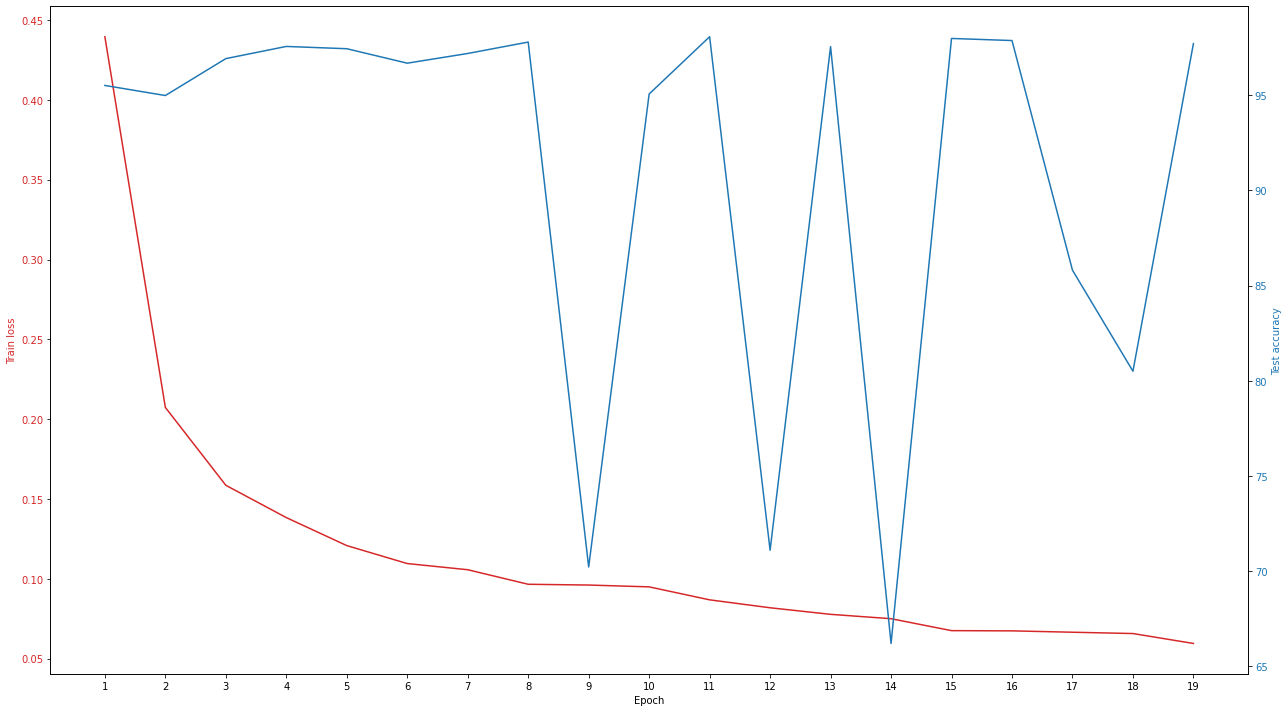

saved model /shares/bulk/earapidis/dev/BinarizedNN/saved_models/lenet_5/model_1/epoch_19.pth
Train Epoch: 20 [0/60000 (0%)]	Loss: 0.016545
Train Epoch: 20 [6400/60000 (11%)]	Loss: 0.045597
Train Epoch: 20 [12800/60000 (21%)]	Loss: 0.074153
Train Epoch: 20 [19200/60000 (32%)]	Loss: 0.065784
Train Epoch: 20 [25600/60000 (43%)]	Loss: 0.128971
Train Epoch: 20 [32000/60000 (53%)]	Loss: 0.114486
Train Epoch: 20 [38400/60000 (64%)]	Loss: 0.028456
Train Epoch: 20 [44800/60000 (75%)]	Loss: 0.027286
Train Epoch: 20 [51200/60000 (85%)]	Loss: 0.067448
Train Epoch: 20 [57600/60000 (96%)]	Loss: 0.036734

Test set: Average loss: 0.0001, Accuracy: 9811/10000 (98%)

[0.016544848680496216, 0.04788002371788025, 0.016961997374892235, 0.1102142333984375, 0.1331547349691391, 0.08021373301744461, 0.012142421677708626, 0.035278916358947754, 0.06848127394914627, 0.008774674497544765, 0.1026633009314537, 0.04382695257663727, 0.021964259445667267, 0.02362816035747528, 0.02279728092253208, 0.050765421241521835, 0

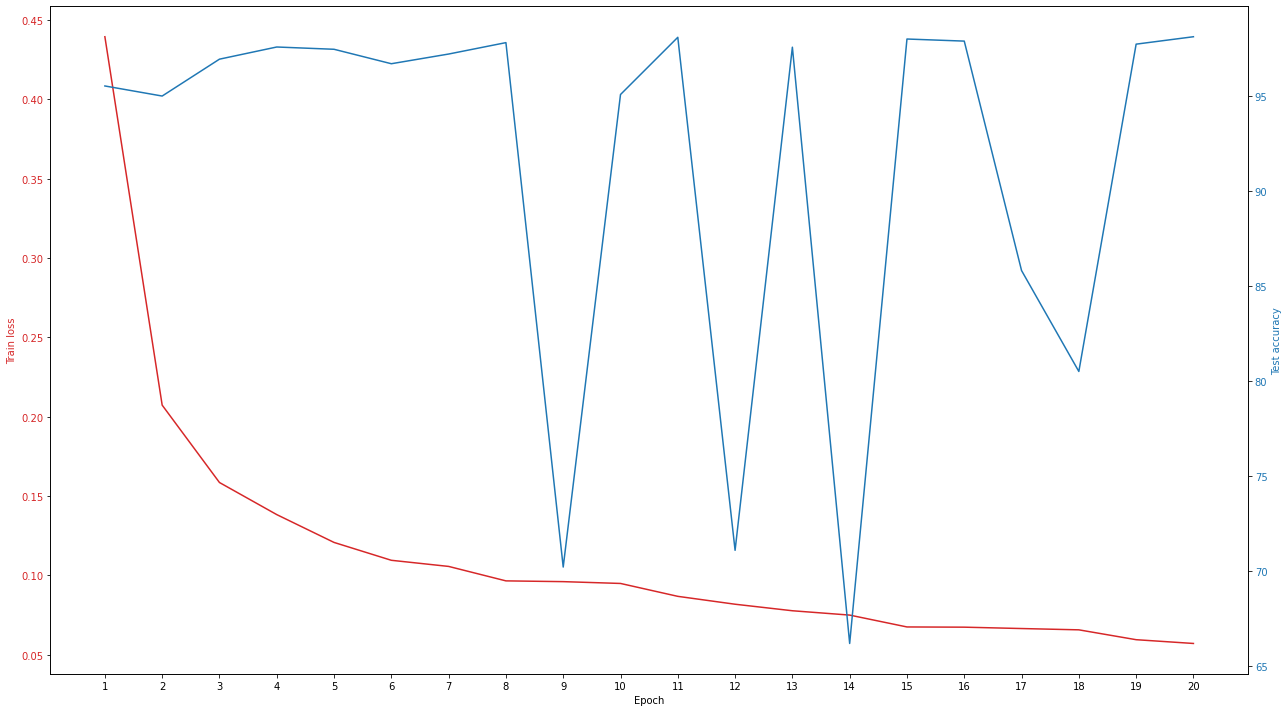

saved model /shares/bulk/earapidis/dev/BinarizedNN/saved_models/lenet_5/model_1/epoch_20.pth
Train Epoch: 21 [0/60000 (0%)]	Loss: 0.038387
Train Epoch: 21 [6400/60000 (11%)]	Loss: 0.118413
Train Epoch: 21 [12800/60000 (21%)]	Loss: 0.023858
Train Epoch: 21 [19200/60000 (32%)]	Loss: 0.063791
Train Epoch: 21 [25600/60000 (43%)]	Loss: 0.023246
Train Epoch: 21 [32000/60000 (53%)]	Loss: 0.076243
Train Epoch: 21 [38400/60000 (64%)]	Loss: 0.045452
Train Epoch: 21 [44800/60000 (75%)]	Loss: 0.154967
Train Epoch: 21 [51200/60000 (85%)]	Loss: 0.138484
Train Epoch: 21 [57600/60000 (96%)]	Loss: 0.041243

Test set: Average loss: 0.0001, Accuracy: 9773/10000 (98%)

[0.03838665038347244, 0.2220064103603363, 0.018795888870954514, 0.07997328042984009, 0.043721336871385574, 0.06891690939664841, 0.05337544158101082, 0.03480790555477142, 0.07875270396471024, 0.15587839484214783, 0.0630962997674942, 0.027597511187195778, 0.047780685126781464, 0.06475106626749039, 0.01178989838808775, 0.007732567377388477, 0.

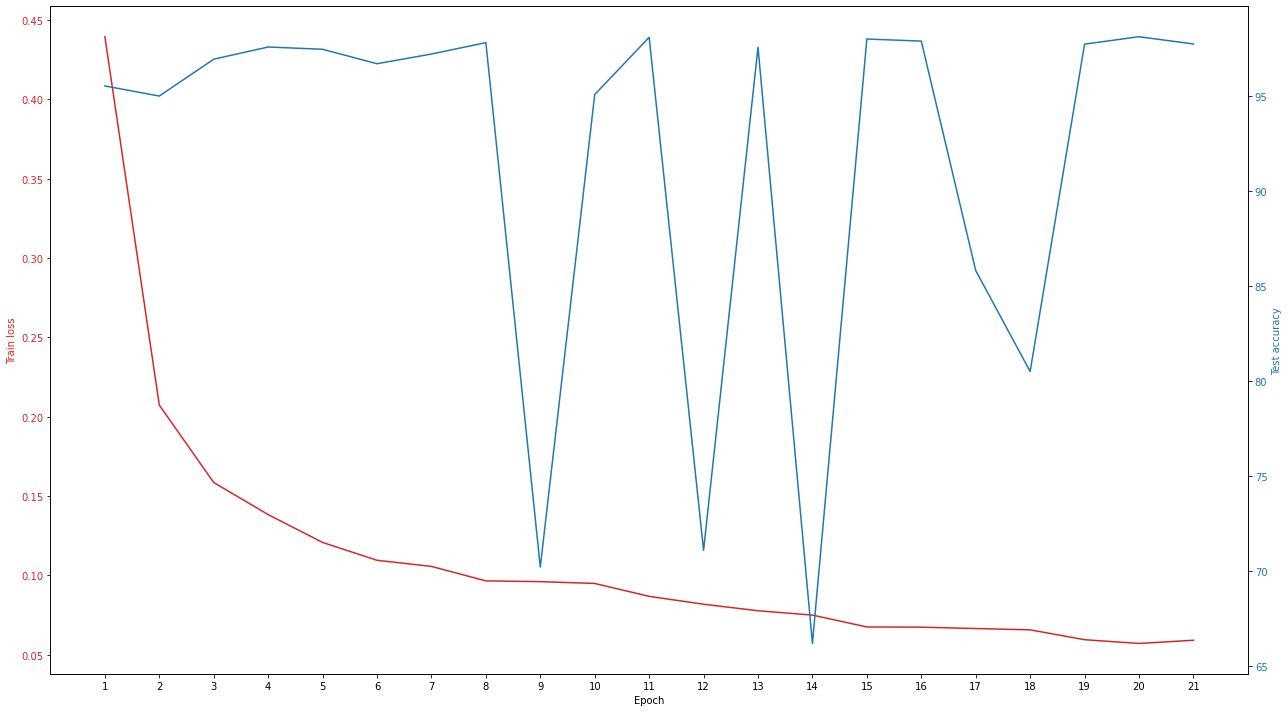

saved model /shares/bulk/earapidis/dev/BinarizedNN/saved_models/lenet_5/model_1/epoch_21.pth
Train Epoch: 22 [0/60000 (0%)]	Loss: 0.050324
Train Epoch: 22 [6400/60000 (11%)]	Loss: 0.038110
Train Epoch: 22 [12800/60000 (21%)]	Loss: 0.011220
Train Epoch: 22 [19200/60000 (32%)]	Loss: 0.007416
Train Epoch: 22 [25600/60000 (43%)]	Loss: 0.049741
Train Epoch: 22 [32000/60000 (53%)]	Loss: 0.019294
Train Epoch: 22 [38400/60000 (64%)]	Loss: 0.050903
Train Epoch: 22 [44800/60000 (75%)]	Loss: 0.018177
Train Epoch: 22 [51200/60000 (85%)]	Loss: 0.024272
Train Epoch: 22 [57600/60000 (96%)]	Loss: 0.010352

Test set: Average loss: 0.0001, Accuracy: 9800/10000 (98%)

[0.05032416433095932, 0.045379143208265305, 0.05303797870874405, 0.10517852753400803, 0.01339657325297594, 0.03184393048286438, 0.09236013144254684, 0.015450848266482353, 0.059210240840911865, 0.1928945630788803, 0.01831197179853916, 0.010729624889791012, 0.014547460712492466, 0.2256792038679123, 0.02869146317243576, 0.007932380773127079, 0

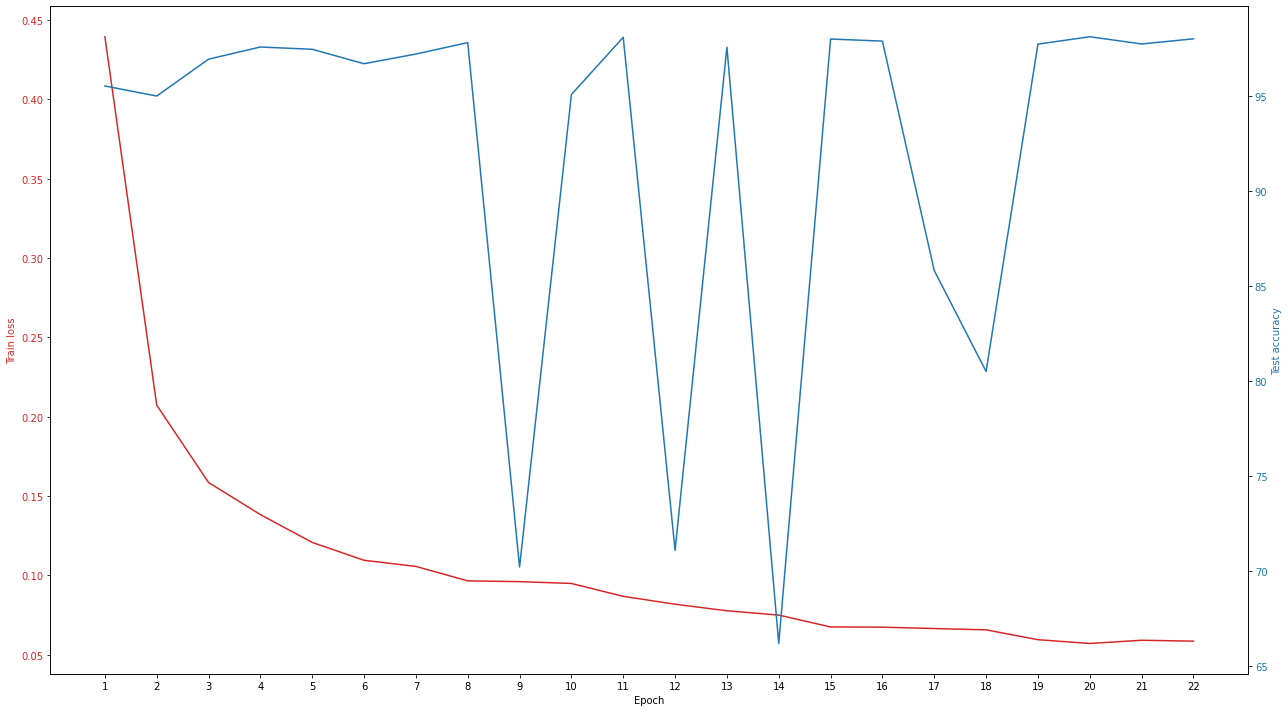

saved model /shares/bulk/earapidis/dev/BinarizedNN/saved_models/lenet_5/model_1/epoch_22.pth
Train Epoch: 23 [0/60000 (0%)]	Loss: 0.015361
Train Epoch: 23 [6400/60000 (11%)]	Loss: 0.105571
Train Epoch: 23 [12800/60000 (21%)]	Loss: 0.077296
Train Epoch: 23 [19200/60000 (32%)]	Loss: 0.060345
Train Epoch: 23 [25600/60000 (43%)]	Loss: 0.012308
Train Epoch: 23 [32000/60000 (53%)]	Loss: 0.119544
Train Epoch: 23 [38400/60000 (64%)]	Loss: 0.010653
Train Epoch: 23 [44800/60000 (75%)]	Loss: 0.062889
Train Epoch: 23 [51200/60000 (85%)]	Loss: 0.006994
Train Epoch: 23 [57600/60000 (96%)]	Loss: 0.106968

Test set: Average loss: 0.0001, Accuracy: 9731/10000 (97%)

[0.015361079946160316, 0.022555435076355934, 0.030384376645088196, 0.006179378367960453, 0.0172503013163805, 0.024532608687877655, 0.02536933310329914, 0.021754447370767593, 0.0736621543765068, 0.015535938553512096, 0.06997616589069366, 0.005446000024676323, 0.1471794843673706, 0.02903253771364689, 0.06867312639951706, 0.09408831596374512, 

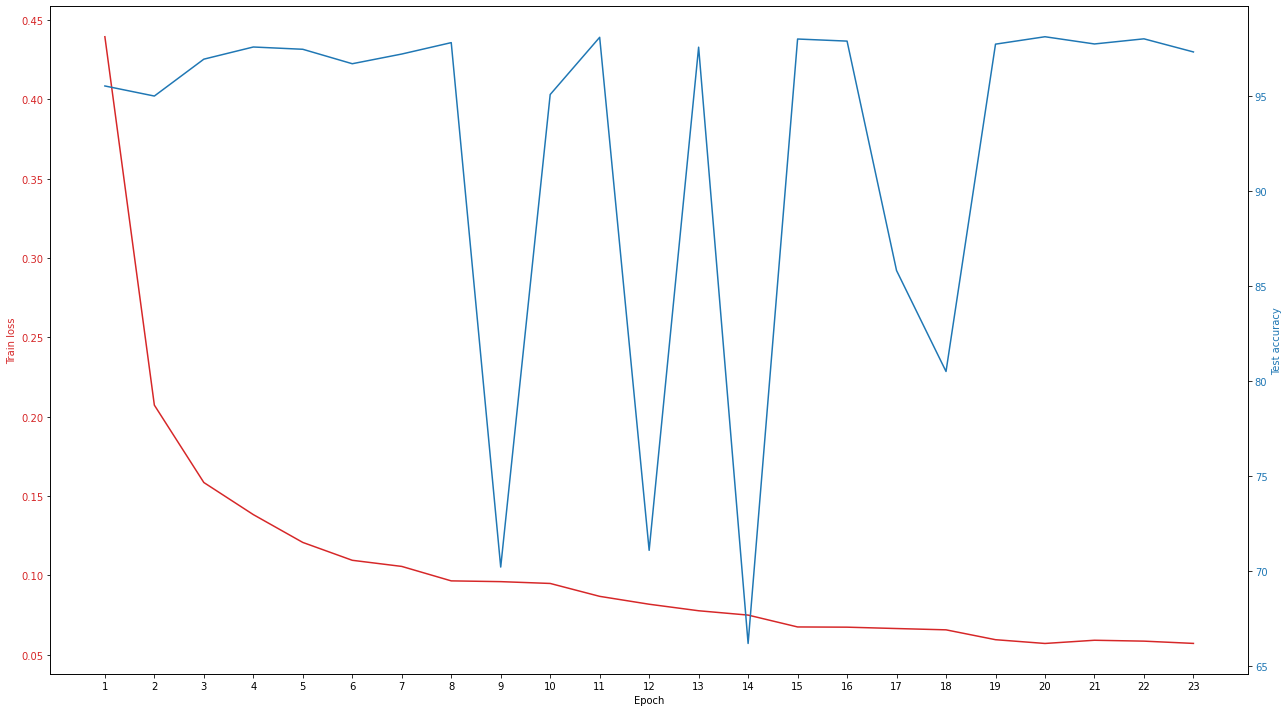

saved model /shares/bulk/earapidis/dev/BinarizedNN/saved_models/lenet_5/model_1/epoch_23.pth
Train Epoch: 24 [0/60000 (0%)]	Loss: 0.059529
Train Epoch: 24 [6400/60000 (11%)]	Loss: 0.009036
Train Epoch: 24 [12800/60000 (21%)]	Loss: 0.013482
Train Epoch: 24 [19200/60000 (32%)]	Loss: 0.163763
Train Epoch: 24 [25600/60000 (43%)]	Loss: 0.019473
Train Epoch: 24 [32000/60000 (53%)]	Loss: 0.141439
Train Epoch: 24 [38400/60000 (64%)]	Loss: 0.102285
Train Epoch: 24 [44800/60000 (75%)]	Loss: 0.056391
Train Epoch: 24 [51200/60000 (85%)]	Loss: 0.006244
Train Epoch: 24 [57600/60000 (96%)]	Loss: 0.029207

Test set: Average loss: 0.0001, Accuracy: 9768/10000 (98%)

[0.05952923372387886, 0.071015365421772, 0.010515634901821613, 0.007306857965886593, 0.06055087596178055, 0.049646422266960144, 0.06437643617391586, 0.020546196028590202, 0.030975162982940674, 0.025408977642655373, 0.02361302450299263, 0.051050424575805664, 0.06133485212922096, 0.006552761420607567, 0.04062263295054436, 0.035167988389730453

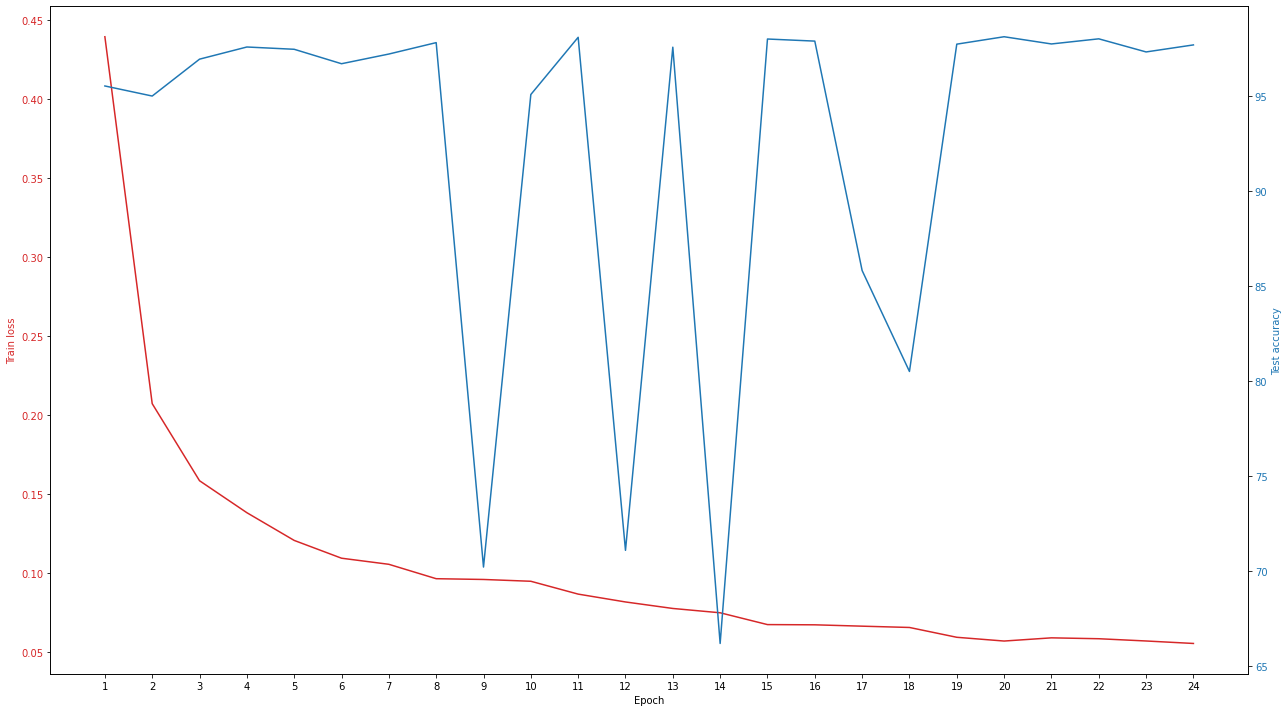

saved model /shares/bulk/earapidis/dev/BinarizedNN/saved_models/lenet_5/model_1/epoch_24.pth
Train Epoch: 25 [0/60000 (0%)]	Loss: 0.025644
Train Epoch: 25 [6400/60000 (11%)]	Loss: 0.128092
Train Epoch: 25 [12800/60000 (21%)]	Loss: 0.014625
Train Epoch: 25 [19200/60000 (32%)]	Loss: 0.018852
Train Epoch: 25 [25600/60000 (43%)]	Loss: 0.061939
Train Epoch: 25 [32000/60000 (53%)]	Loss: 0.050945
Train Epoch: 25 [38400/60000 (64%)]	Loss: 0.035488
Train Epoch: 25 [44800/60000 (75%)]	Loss: 0.040871
Train Epoch: 25 [51200/60000 (85%)]	Loss: 0.133334
Train Epoch: 25 [57600/60000 (96%)]	Loss: 0.025882

Test set: Average loss: 0.0001, Accuracy: 9807/10000 (98%)

[0.025643767789006233, 0.05300045385956764, 0.059223804622888565, 0.02708113007247448, 0.014202376827597618, 0.02367164008319378, 0.198195219039917, 0.06736297160387039, 0.026802584528923035, 0.02541070431470871, 0.08066218346357346, 0.008229630067944527, 0.10116764158010483, 0.0600174181163311, 0.11062531173229218, 0.14178436994552612, 0.0

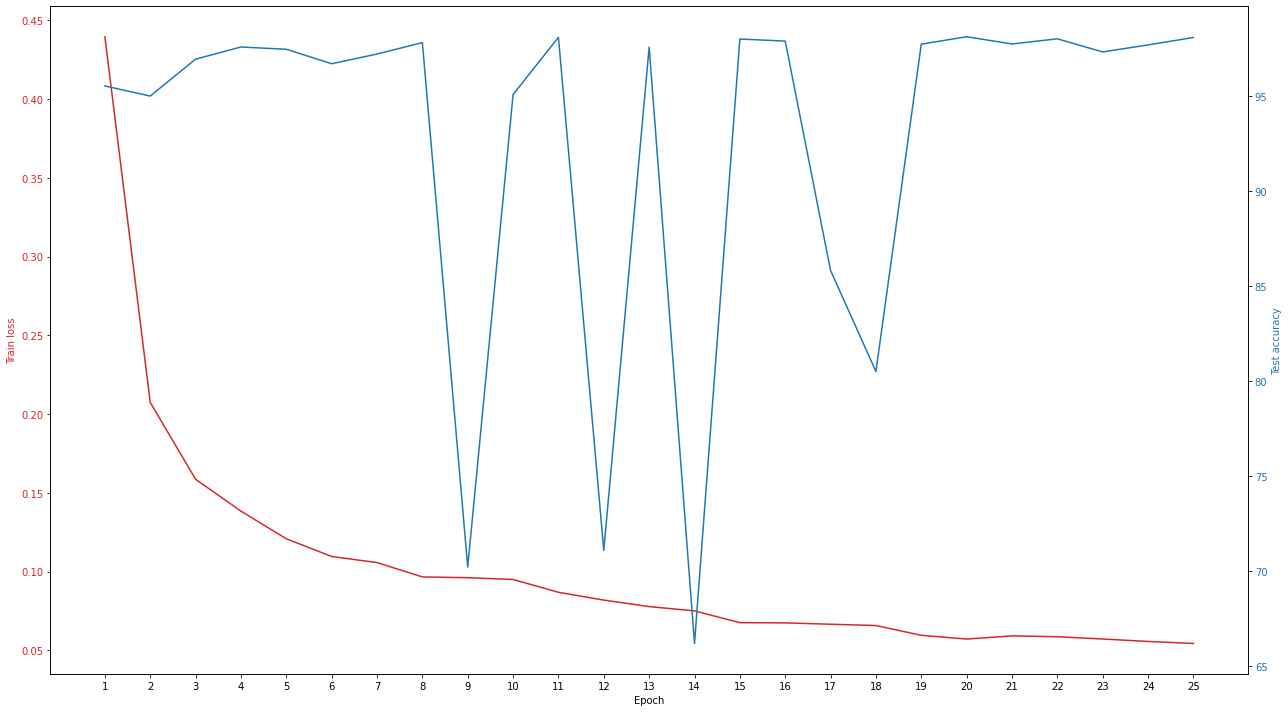

saved model /shares/bulk/earapidis/dev/BinarizedNN/saved_models/lenet_5/model_1/epoch_25.pth
Train Epoch: 26 [0/60000 (0%)]	Loss: 0.116012
Train Epoch: 26 [6400/60000 (11%)]	Loss: 0.019467
Train Epoch: 26 [12800/60000 (21%)]	Loss: 0.026228
Train Epoch: 26 [19200/60000 (32%)]	Loss: 0.028741
Train Epoch: 26 [25600/60000 (43%)]	Loss: 0.031033
Train Epoch: 26 [32000/60000 (53%)]	Loss: 0.021579
Train Epoch: 26 [38400/60000 (64%)]	Loss: 0.044834
Train Epoch: 26 [44800/60000 (75%)]	Loss: 0.015276
Train Epoch: 26 [51200/60000 (85%)]	Loss: 0.049565
Train Epoch: 26 [57600/60000 (96%)]	Loss: 0.025712

Test set: Average loss: 0.0001, Accuracy: 9766/10000 (98%)

[0.11601221561431885, 0.015562276355922222, 0.03499337658286095, 0.011569409631192684, 0.07663127034902573, 0.046476561576128006, 0.07833502441644669, 0.04390883818268776, 0.043010689318180084, 0.022548796609044075, 0.019670678302645683, 0.010818756185472012, 0.03460992872714996, 0.07288623601198196, 0.0640624612569809, 0.09244881570339203,

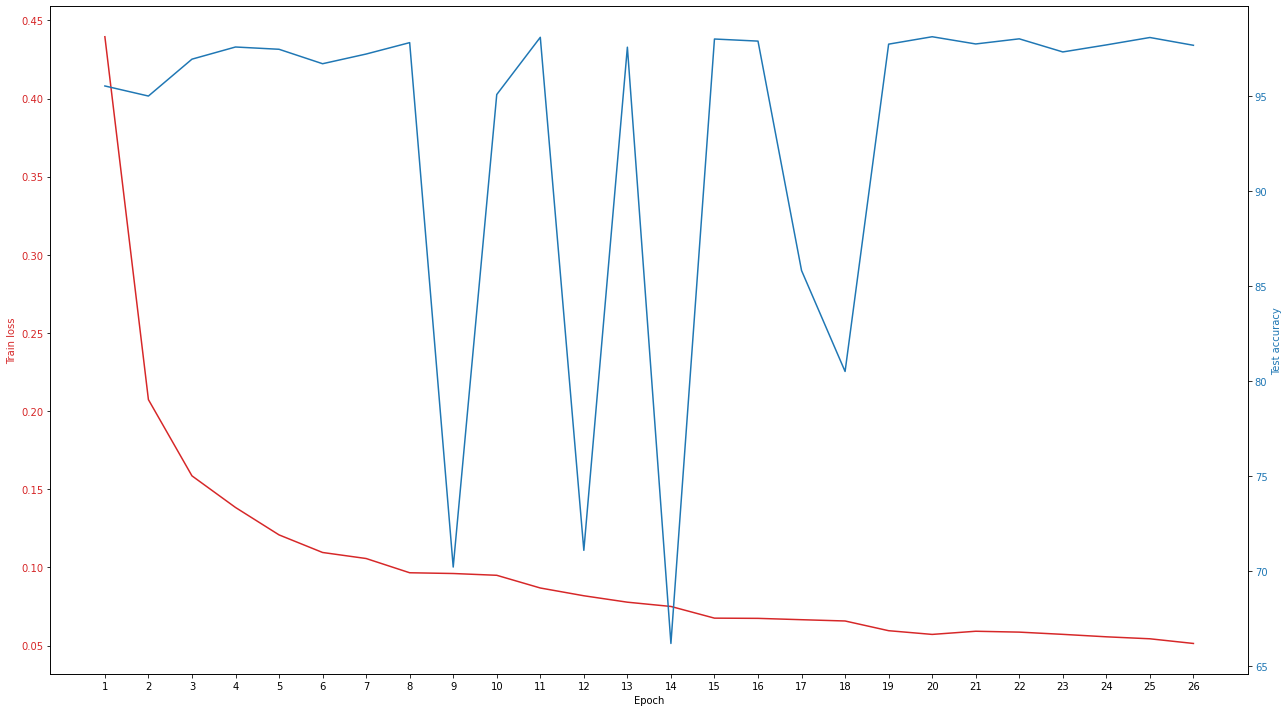

saved model /shares/bulk/earapidis/dev/BinarizedNN/saved_models/lenet_5/model_1/epoch_26.pth
Train Epoch: 27 [0/60000 (0%)]	Loss: 0.056286
Train Epoch: 27 [6400/60000 (11%)]	Loss: 0.053777
Train Epoch: 27 [12800/60000 (21%)]	Loss: 0.068857
Train Epoch: 27 [19200/60000 (32%)]	Loss: 0.046582
Train Epoch: 27 [25600/60000 (43%)]	Loss: 0.072484
Train Epoch: 27 [32000/60000 (53%)]	Loss: 0.030633
Train Epoch: 27 [38400/60000 (64%)]	Loss: 0.020345
Train Epoch: 27 [44800/60000 (75%)]	Loss: 0.108283
Train Epoch: 27 [51200/60000 (85%)]	Loss: 0.029542
Train Epoch: 27 [57600/60000 (96%)]	Loss: 0.010455

Test set: Average loss: 0.0001, Accuracy: 9784/10000 (98%)

[0.05628645420074463, 0.19853141903877258, 0.00693473918363452, 0.013340040110051632, 0.06347579509019852, 0.047006070613861084, 0.053667694330215454, 0.01986760087311268, 0.02249508537352085, 0.08536285907030106, 0.07129627466201782, 0.007557212840765715, 0.018642621114850044, 0.07172191888093948, 0.0047049145214259624, 0.01426254864782095

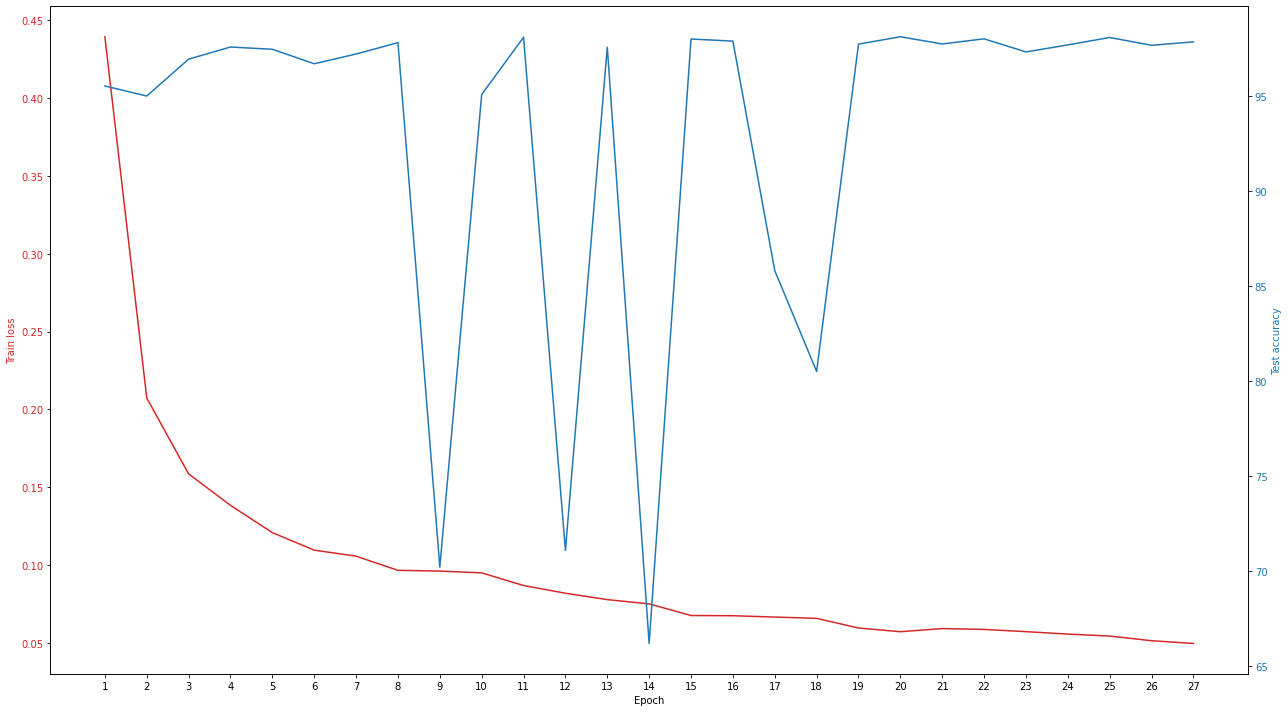

saved model /shares/bulk/earapidis/dev/BinarizedNN/saved_models/lenet_5/model_1/epoch_27.pth
Train Epoch: 28 [0/60000 (0%)]	Loss: 0.187370
Train Epoch: 28 [6400/60000 (11%)]	Loss: 0.084656
Train Epoch: 28 [12800/60000 (21%)]	Loss: 0.019390
Train Epoch: 28 [19200/60000 (32%)]	Loss: 0.012257
Train Epoch: 28 [25600/60000 (43%)]	Loss: 0.094211
Train Epoch: 28 [32000/60000 (53%)]	Loss: 0.053004
Train Epoch: 28 [38400/60000 (64%)]	Loss: 0.010442
Train Epoch: 28 [44800/60000 (75%)]	Loss: 0.043740
Train Epoch: 28 [51200/60000 (85%)]	Loss: 0.011935
Train Epoch: 28 [57600/60000 (96%)]	Loss: 0.038254

Test set: Average loss: 0.0001, Accuracy: 9803/10000 (98%)

[0.18736979365348816, 0.020508987829089165, 0.008877997286617756, 0.0201750248670578, 0.0086586344987154, 0.06447657197713852, 0.011991147883236408, 0.07011620700359344, 0.009831749834120274, 0.10389778017997742, 0.004344271961599588, 0.010058632120490074, 0.009663507342338562, 0.03971532732248306, 0.050151512026786804, 0.024407068267464638

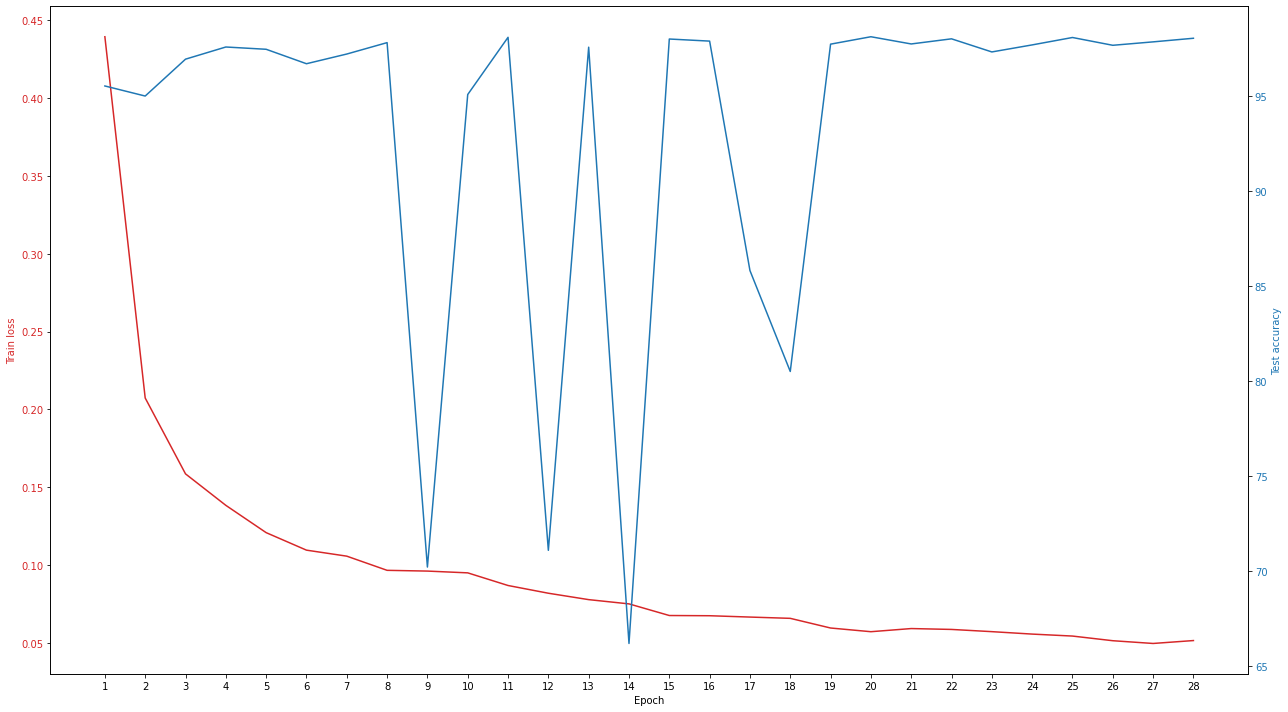

saved model /shares/bulk/earapidis/dev/BinarizedNN/saved_models/lenet_5/model_1/epoch_28.pth
Train Epoch: 29 [0/60000 (0%)]	Loss: 0.252269
Train Epoch: 29 [6400/60000 (11%)]	Loss: 0.057632
Train Epoch: 29 [12800/60000 (21%)]	Loss: 0.010311
Train Epoch: 29 [19200/60000 (32%)]	Loss: 0.075709
Train Epoch: 29 [25600/60000 (43%)]	Loss: 0.036673
Train Epoch: 29 [32000/60000 (53%)]	Loss: 0.062625
Train Epoch: 29 [38400/60000 (64%)]	Loss: 0.116666
Train Epoch: 29 [44800/60000 (75%)]	Loss: 0.010834
Train Epoch: 29 [51200/60000 (85%)]	Loss: 0.043280
Train Epoch: 29 [57600/60000 (96%)]	Loss: 0.078473

Test set: Average loss: 0.0001, Accuracy: 9808/10000 (98%)

[0.25226929783821106, 0.0512692965567112, 0.12845584750175476, 0.11989860981702805, 0.015966085717082024, 0.031763896346092224, 0.01403906662017107, 0.04003092274069786, 0.016116471961140633, 0.023324215784668922, 0.03280111402273178, 0.004208593629300594, 0.014150727540254593, 0.028615131974220276, 0.02982611395418644, 0.04498592019081116,

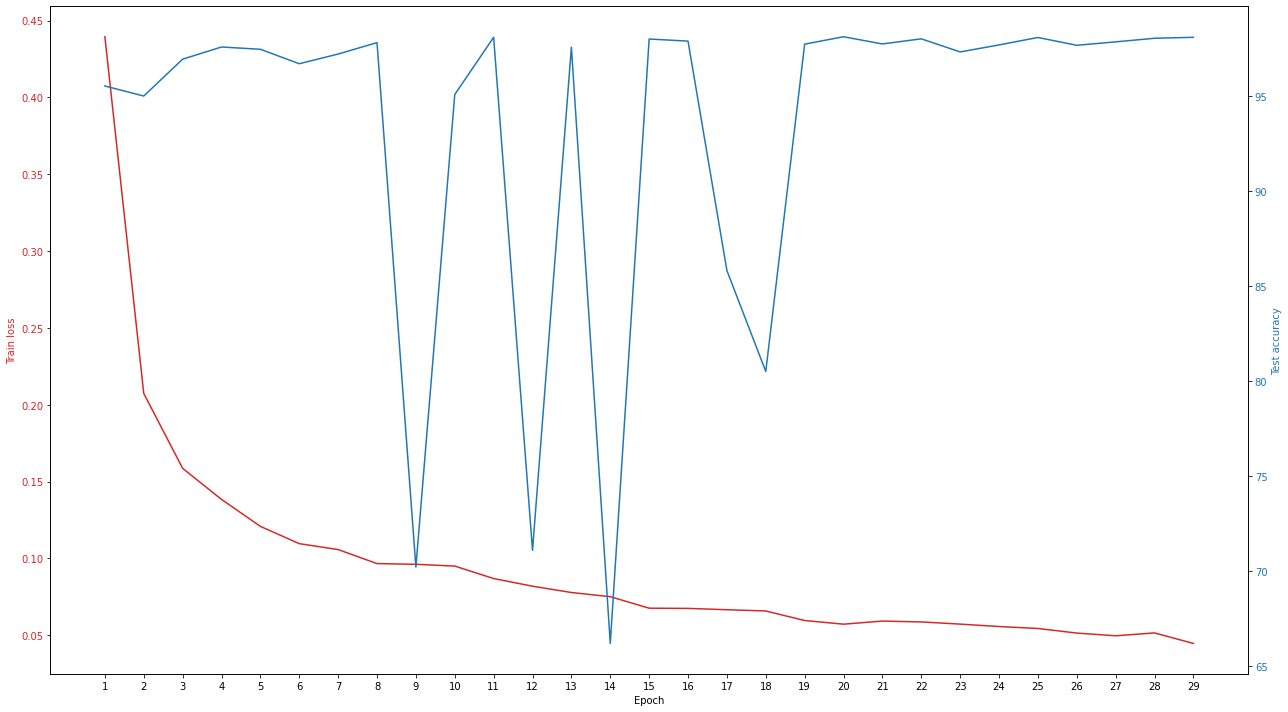

saved model /shares/bulk/earapidis/dev/BinarizedNN/saved_models/lenet_5/model_1/epoch_29.pth
Train Epoch: 30 [0/60000 (0%)]	Loss: 0.005885
Train Epoch: 30 [6400/60000 (11%)]	Loss: 0.011418
Train Epoch: 30 [12800/60000 (21%)]	Loss: 0.090526
Train Epoch: 30 [19200/60000 (32%)]	Loss: 0.023828
Train Epoch: 30 [25600/60000 (43%)]	Loss: 0.029642
Train Epoch: 30 [32000/60000 (53%)]	Loss: 0.078712
Train Epoch: 30 [38400/60000 (64%)]	Loss: 0.059444
Train Epoch: 30 [44800/60000 (75%)]	Loss: 0.014589
Train Epoch: 30 [51200/60000 (85%)]	Loss: 0.186299
Train Epoch: 30 [57600/60000 (96%)]	Loss: 0.009214

Test set: Average loss: 0.0001, Accuracy: 9788/10000 (98%)

[0.00588464830070734, 0.00917470920830965, 0.0513748936355114, 0.05392376333475113, 0.007914244197309017, 0.07882057130336761, 0.06195820868015289, 0.08964469283819199, 0.016295796260237694, 0.008231446146965027, 0.08976724743843079, 0.007492138538509607, 0.05426573380827904, 0.024628568440675735, 0.03659465163946152, 0.013738477602601051, 

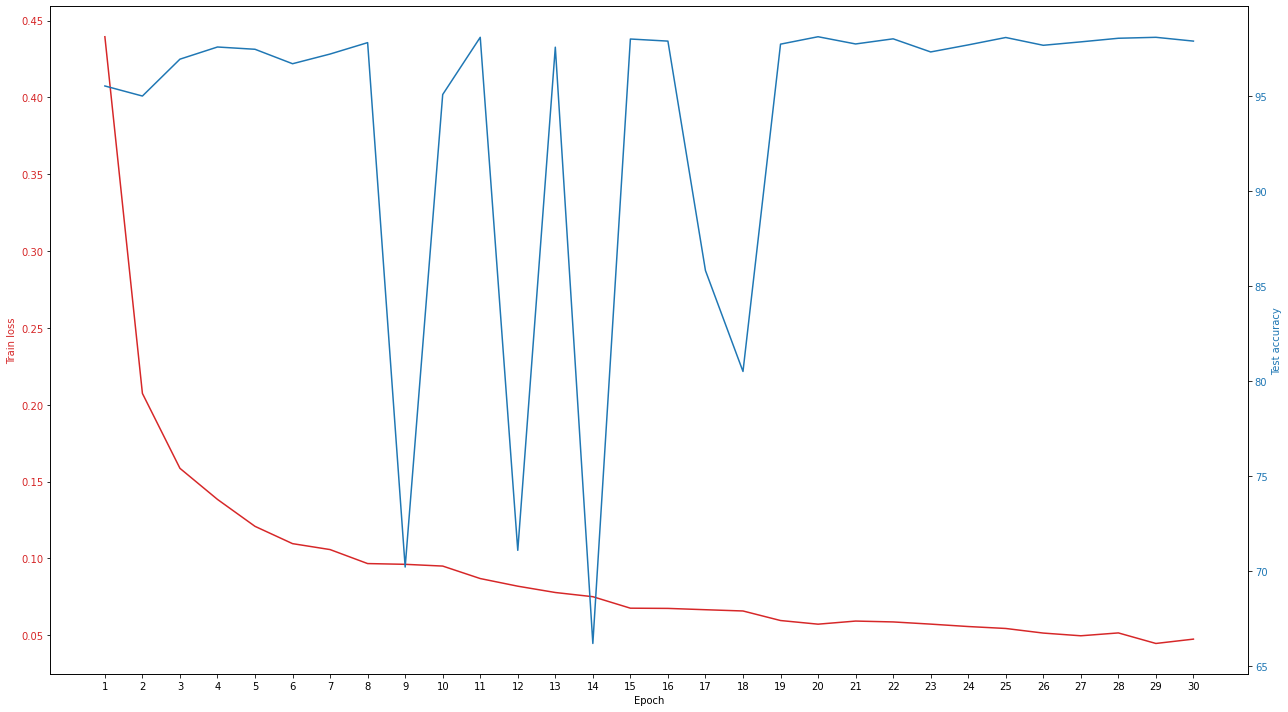

saved model /shares/bulk/earapidis/dev/BinarizedNN/saved_models/lenet_5/model_1/epoch_30.pth


In [44]:
test_accuracy_list = []
train_loss_list = []
for epoch in range(1, epochs + 1):
    train_loss = train(epoch)
    test_accuracy = test()


    if epoch%40==0:
        optimizer.param_groups[0]['lr']=optimizer.param_groups[0]['lr']*0.1

    x_axis = np.arange(1,epoch+1)
    test_accuracy_list.append(test_accuracy)
    train_loss_list.append(np.mean(train_loss))
    # plt.plot()
    print(train_loss)
    print(train_loss_list)
    
    fig, ax1 = plt.subplots()
    x_axis = np.arange(1,epoch+1,dtype=int)
    fig.set_size_inches(18,10)

    ax1.set_xticks(x_axis)
    color = 'tab:red'
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Train loss', color=color)
    ax1.plot(x_axis, train_loss_list, color=color)
    ax1.tick_params(axis='y', labelcolor=color)

    ax2 = ax1.twinx()  # instantiate a second Axes that shares the same x-axis

    color = 'tab:blue'
    ax2.set_ylabel('Test accuracy', color=color)  # we already handled the x-label with ax1
    ax2.plot(x_axis, test_accuracy_list, color=color)
    ax2.tick_params(axis='y', labelcolor=color)

    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    plt.show()
    model_path = os.path.join(models_path,f"epoch_{epoch}.pth")
    torch.save(model.state_dict(), model_path)
    print(f"saved model {model_path}")


In [45]:
best_epoch = np.argmax(test_accuracy_list)+1
best_epoch

20

In [46]:
model_path = os.path.join(models_path,f"epoch_{best_epoch}.pth")
model = Net()
model.load_state_dict(torch.load(model_path))


<All keys matched successfully>

In [47]:
model_path

'/shares/bulk/earapidis/dev/BinarizedNN/saved_models/lenet_5/model_1/epoch_20.pth'

In [48]:
model_path = os.path.join(models_path,f"best.pth")
torch.save(model.state_dict(), model_path)
print(f"saved model {model_path}")

saved model /shares/bulk/earapidis/dev/BinarizedNN/saved_models/lenet_5/model_1/best.pth


In [49]:
# test()

RuntimeError: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same